# Trivial GAN 
This notebook is uning 1 dimensional distrubution to fit the the two dimensional distrution, and we can check out what will happen when uning low dimensional disrubution to fit high dimensional data.(Just like evey generative model task)

## Dimension mapping lemma 
>Let $𝑔:𝒵→𝒳$ be a function composed by ***affine transformation*** and ***pointwise nonlinearities***. 

>Then, $𝑔(𝒵)$ is contained in a countable union of manifolds of dimension at most $\text{dim}𝒵$.

>i.e. $\text{dim} 𝑔(𝒵)≤\text{dim} 𝒵$.

>Therefore, if $\text{dim} 𝒵 <\text{dim} 𝒳$, then $𝑔(𝒵)$ will be measure 0 in $𝒳$.

*Martin Arjovsky and L ́eon Bottou. Towards principled methods for training generative adversarial networks. InInternational Conference on Learning Representations, 2017.*

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

### Build toy set

In [2]:
Fixpoint_num=7

In [3]:
FixpointX = np.random.rand(Fixpoint_num)

In [4]:
FixpointX = FixpointX*2-1

In [5]:
FixpointY = np.random.rand(Fixpoint_num)
FixpointY = FixpointY*2-1

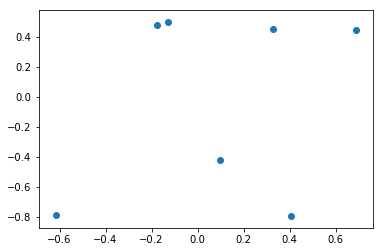

In [6]:
plt.scatter(FixpointX,FixpointY)

In [7]:
NoiseScale = 0.25

In [8]:
zip(FixpointX,FixpointY)

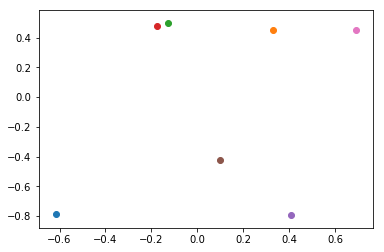

In [9]:
for fixpoint in zip(FixpointX,FixpointY):
  plt.scatter(fixpoint[0],fixpoint[1])

In [10]:
Data_X = []
Data_Y = []
for fixpoint in zip(FixpointX,FixpointY):
    noise_scale_x = NoiseScale*np.random.rand(1)
    noise_scale_y = NoiseScale*np.random.rand(1)
    simX = noise_scale_x*np.random.randn(1000)+fixpoint[0]
    simY = noise_scale_y*np.random.randn(1000)+fixpoint[1]
    Data_X.append(simX)
    Data_Y.append(simY)
Data_X = np.array(Data_X)
Data_Y = np.array(Data_Y)

In [11]:
Data_X.shape

(7, 1000)

In [12]:
flatX = Data_X.flatten()
flatY = Data_Y.flatten()

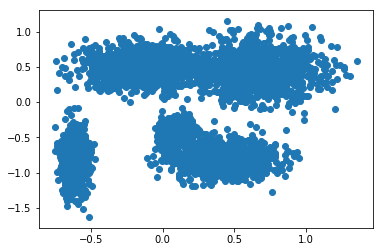

In [13]:
plt.scatter(flatX,flatY)

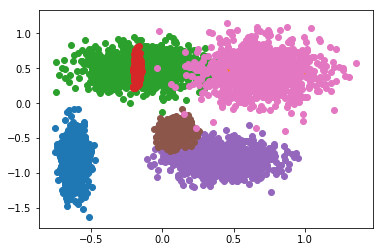

In [14]:
for fixpoint in zip(Data_X,Data_Y):
    plt.scatter(fixpoint[0],fixpoint[1])

### Build GAN

In [15]:
from keras.layers import Dense, Input, Activation, LeakyReLU
from keras.models import Model,Sequential
from keras import activations

/home/mathlab115/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [16]:
def Build_GAN(InputDim):
    Generator = Sequential(name='Generator')
    Generator.add(Dense(100, input_dim=InputDim))
    Generator.add(LeakyReLU())
    Generator.add(Dense(10))
    Generator.add(LeakyReLU())
    Generator.add(Dense(2, name='output'))
    Generator.add(LeakyReLU())
    print('Generator')
    Generator.summary()
    Discriminator = Sequential(name='Discriminator')
    Discriminator.add(Dense(100, input_dim=2))
    Discriminator.add(LeakyReLU())
    Discriminator.add(Dense(10))
    Discriminator.add(LeakyReLU())
    Discriminator.add(Dense(1, activation='sigmoid'))
    print('Discriminator')
    Discriminator.summary()
    return Generator, Discriminator

In [17]:
Generator, Discriminator =Build_GAN(1)

Generator
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 100)               200       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 100)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 10)                1010      
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 10)                0         
_________________________________________________________________
output (Dense)               (None, 2)                 22        
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 2)                 0         
Total params: 1,232
Trainable params: 1,232
Non-trainable params: 0
________________________________________________________________

In [18]:
#Model for Train_Generator 
Discriminator.trainable = False

g_in = Input(shape=(1,))
g_out = Generator(g_in)
true_in = Input(shape=(2,))
fake_out = Discriminator(g_out)
true_out = Discriminator(true_in)

TrainGeneratorModel = Model([g_in,true_in],[fake_out, true_out])
TrainGeneratorModel.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_1 (InputLayer)             (None, 1)             0                                            
____________________________________________________________________________________________________
Generator (Sequential)           (None, 2)             1232        input_1[0][0]                    
____________________________________________________________________________________________________
input_2 (InputLayer)             (None, 2)             0                                            
____________________________________________________________________________________________________
Discriminator (Sequential)       (None, 1)             1321        Generator[1][0]                  
                                                                   input_2[0][0]           

In [19]:
from keras.optimizers import  Adam, SGD

In [20]:
OPT=Adam()

In [21]:
TrainGeneratorModel.compile(OPT, loss='binary_crossentropy')
Discriminator.trainable=True
Discriminator.compile(OPT, loss='binary_crossentropy')

In [22]:
TrainGeneratorModel.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_1 (InputLayer)             (None, 1)             0                                            
____________________________________________________________________________________________________
Generator (Sequential)           (None, 2)             1232        input_1[0][0]                    
____________________________________________________________________________________________________
input_2 (InputLayer)             (None, 2)             0                                            
____________________________________________________________________________________________________
Discriminator (Sequential)       (None, 1)             1321        Generator[1][0]                  
                                                                   input_2[0][0]           

In [23]:
iteration_num = 20000
batch_size = 32

In [24]:
flatXY = np.array(list(zip(flatX,flatY)))
flatXY.shape

(7000, 2)

### GAN Training

In [25]:
index = np.arange(Fixpoint_num*1000)
Epochs = 88
D_Loss_list = []
G_Loss_list = []
Generated = []
batch_numbers = Fixpoint_num*1000//batch_size
for epoch in range(Epochs):
    np.random.shuffle(flatXY)
    for batch_num in range(batch_numbers):
        Discriminator.trainable = True
        true_data = []
        noise = np.random.normal(0, 1, (batch_size,1))
        fake_data = Generator.predict_on_batch(noise)
        for i in range(batch_size):
            true_data.append(flatXY[index[batch_num+i]])
        true_data = np.array(true_data)
        combine_X = np.array((fake_data, true_data)).reshape(64,2)
        combine_Y = np.concatenate((np.zeros((32,1)), np.ones((32,1)) )).reshape(64,1)
        D_Loss = Discriminator.train_on_batch(combine_X, combine_Y)
        D_Loss_list.append(D_Loss)
        Discriminator.trainable = False
        noise = np.random.normal(0, 1, (batch_size,1))
        G_Loss = TrainGeneratorModel.train_on_batch([noise, true_data],[np.ones((32,1)),  np.ones((32,1))])
        G_Loss_list.append(G_Loss)
  
    print('Epoch {} Done'.format(epoch))
    print('Generator Loss:     {}'.format(G_Loss))
    print('Discriminator Loss: {}'.format(D_Loss))
    noise = np.random.normal(0, 1, (1000,1))
    Generated.append(Generator.predict(noise))
  

Epoch 0 Done
Generator Loss:     [1.7389387, 0.9562931, 0.7826456]
Discriminator Loss: 0.6427850723266602
Epoch 1 Done
Generator Loss:     [1.4473023, 0.7405126, 0.7067898]
Discriminator Loss: 0.7006511688232422
Epoch 2 Done
Generator Loss:     [1.3641412, 0.71377754, 0.65036374]
Discriminator Loss: 0.6807993650436401
Epoch 3 Done
Generator Loss:     [1.2800529, 0.6450342, 0.63501865]
Discriminator Loss: 0.6647446155548096
Epoch 4 Done
Generator Loss:     [1.4698708, 0.86853075, 0.6013401]
Discriminator Loss: 0.5754052996635437
Epoch 5 Done
Generator Loss:     [1.5216885, 0.7835061, 0.7381823]
Discriminator Loss: 0.685444176197052
Epoch 6 Done
Generator Loss:     [1.4006925, 0.7471156, 0.6535768]
Discriminator Loss: 0.645534098148346
Epoch 7 Done
Generator Loss:     [1.3257339, 0.6876928, 0.638041]
Discriminator Loss: 0.6504272222518921
Epoch 8 Done
Generator Loss:     [1.3916918, 0.7003839, 0.6913079]
Discriminator Loss: 0.7490478754043579
Epoch 9 Done
Generator Loss:     [1.4048891, 

Epoch 77 Done
Generator Loss:     [1.444237, 0.82531834, 0.61891866]
Discriminator Loss: 0.6144828796386719
Epoch 78 Done
Generator Loss:     [1.4645104, 0.7938793, 0.67063123]
Discriminator Loss: 0.6726066470146179
Epoch 79 Done
Generator Loss:     [1.5038093, 0.8490875, 0.65472186]
Discriminator Loss: 0.6400402784347534
Epoch 80 Done
Generator Loss:     [1.7233719, 1.0332775, 0.69009435]
Discriminator Loss: 0.6004725694656372
Epoch 81 Done
Generator Loss:     [1.5029213, 0.8037509, 0.6991704]
Discriminator Loss: 0.6282303929328918
Epoch 82 Done
Generator Loss:     [1.378289, 0.80017126, 0.5781178]
Discriminator Loss: 0.5943700075149536
Epoch 83 Done
Generator Loss:     [1.5081515, 0.8372379, 0.6709137]
Discriminator Loss: 0.6391375660896301
Epoch 84 Done
Generator Loss:     [1.3277704, 0.7306616, 0.5971088]
Discriminator Loss: 0.6403735876083374
Epoch 85 Done
Generator Loss:     [1.4396144, 0.7819958, 0.65761864]
Discriminator Loss: 0.6210058331489563
Epoch 86 Done
Generator Loss:   

### Data Visualization and Interaction with ipywidgets

In [26]:
from ipywidgets import interact, interact_manual

In [27]:
def PlotGererated(epoch):
    plt.scatter(flatX,flatY)
    plt.scatter(Generated[epoch][:,0], Generated[epoch][:,1])
    plt.show()

In [28]:
interact(PlotGererated, epoch=(0, Epochs-1))

<function __main__.PlotGererated>

## If we use 128dim distrubution to fit this toyset, what will happened?

In [29]:
INPUT_DIM = 128
Generator, Discriminator =Build_GAN(INPUT_DIM)
Discriminator.trainable = False

g_in = Input(shape=(INPUT_DIM,))
g_out = Generator(g_in)
true_in = Input(shape=(2,))
fake_out = Discriminator(g_out)
true_out = Discriminator(true_in)

TrainGeneratorModel = Model([g_in,true_in],[fake_out, true_out])
TrainGeneratorModel.compile(OPT, loss='binary_crossentropy')
Discriminator.trainable=True
Discriminator.compile(OPT, loss='binary_crossentropy')


Generator
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6 (Dense)              (None, 100)               12900     
_________________________________________________________________
leaky_re_lu_6 (LeakyReLU)    (None, 100)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 10)                1010      
_________________________________________________________________
leaky_re_lu_7 (LeakyReLU)    (None, 10)                0         
_________________________________________________________________
output (Dense)               (None, 2)                 22        
_________________________________________________________________
leaky_re_lu_8 (LeakyReLU)    (None, 2)                 0         
Total params: 13,932
Trainable params: 13,932
Non-trainable params: 0
______________________________________________________________

In [30]:
index = np.arange(Fixpoint_num*87)
Epochs = 5567
D_Loss_list = []
G_Loss_list = []
Generated = []
batch_numbers = Fixpoint_num*87//batch_size
for epoch in range(Epochs):
    np.random.shuffle(flatXY)
    for batch_num in range(batch_numbers):
        Discriminator.trainable = True
        true_data = []
        noise = np.random.normal(0, 1, (batch_size,INPUT_DIM))
        fake_data = Generator.predict_on_batch(noise)
        for i in range(batch_size):
            true_data.append(flatXY[index[batch_num+i]])
        true_data = np.array(true_data)
        combine_X = np.array((fake_data, true_data)).reshape(64,2)
        combine_Y = np.concatenate((np.zeros((32,1)), np.ones((32,1)) )).reshape(64,1)
        D_Loss = Discriminator.train_on_batch(combine_X, combine_Y)
        D_Loss_list.append(D_Loss)
        Discriminator.trainable = False
        noise = np.random.normal(0, 1, (batch_size,INPUT_DIM))
        G_Loss = TrainGeneratorModel.train_on_batch([noise, true_data],[np.ones((32,1)),  np.ones((32,1))])
        G_Loss_list.append(G_Loss)
  
    print('Epoch {} Done'.format(epoch))
    print('Generator Loss:     {}'.format(G_Loss))
    print('Discriminator Loss: {}'.format(D_Loss))
    noise = np.random.normal(0, 1, (1000,INPUT_DIM))
    Generated.append(Generator.predict(noise))

Epoch 0 Done
Generator Loss:     [1.1726524, 0.4330064, 0.73964596]
Discriminator Loss: 0.9658883810043335
Epoch 1 Done
Generator Loss:     [3.767251, 3.1965835, 0.5706675]
Discriminator Loss: 0.38673436641693115
Epoch 2 Done
Generator Loss:     [0.88441855, 0.34850448, 0.53591406]
Discriminator Loss: 0.8997474908828735
Epoch 3 Done
Generator Loss:     [1.1307567, 0.5417944, 0.5889623]
Discriminator Loss: 0.7355029582977295
Epoch 4 Done
Generator Loss:     [1.2746468, 0.6520617, 0.6225851]
Discriminator Loss: 0.6812421083450317
Epoch 5 Done
Generator Loss:     [1.540991, 0.8914826, 0.64950836]
Discriminator Loss: 0.6207210421562195
Epoch 6 Done
Generator Loss:     [1.8472505, 1.1138651, 0.7333853]
Discriminator Loss: 0.5626462697982788
Epoch 7 Done
Generator Loss:     [1.541302, 0.77143514, 0.7698668]
Discriminator Loss: 0.7069147229194641
Epoch 8 Done
Generator Loss:     [1.5361047, 0.8156134, 0.7204913]
Discriminator Loss: 0.7575559616088867
Epoch 9 Done
Generator Loss:     [1.069498

Epoch 78 Done
Generator Loss:     [1.4595083, 0.7462981, 0.7132102]
Discriminator Loss: 0.705424427986145
Epoch 79 Done
Generator Loss:     [1.5671151, 0.83254117, 0.73457384]
Discriminator Loss: 0.6843177080154419
Epoch 80 Done
Generator Loss:     [1.514024, 0.82279617, 0.69122785]
Discriminator Loss: 0.6672089099884033
Epoch 81 Done
Generator Loss:     [1.3160732, 0.6690612, 0.647012]
Discriminator Loss: 0.6866263151168823
Epoch 82 Done
Generator Loss:     [1.278544, 0.6483605, 0.63018346]
Discriminator Loss: 0.6734048128128052
Epoch 83 Done
Generator Loss:     [1.1987455, 0.6126244, 0.5861211]
Discriminator Loss: 0.6887578964233398
Epoch 84 Done
Generator Loss:     [1.2449682, 0.6308616, 0.61410666]
Discriminator Loss: 0.6876468658447266
Epoch 85 Done
Generator Loss:     [1.3896867, 0.7301128, 0.6595739]
Discriminator Loss: 0.6589064002037048
Epoch 86 Done
Generator Loss:     [1.3702223, 0.72891724, 0.64130515]
Discriminator Loss: 0.6535845994949341
Epoch 87 Done
Generator Loss:    

Epoch 156 Done
Generator Loss:     [1.3654943, 0.6770845, 0.6884097]
Discriminator Loss: 0.6749971508979797
Epoch 157 Done
Generator Loss:     [1.5277432, 0.83247775, 0.6952655]
Discriminator Loss: 0.6363445520401001
Epoch 158 Done
Generator Loss:     [1.308597, 0.7251653, 0.58343166]
Discriminator Loss: 0.668971836566925
Epoch 159 Done
Generator Loss:     [1.436431, 0.78368354, 0.6527475]
Discriminator Loss: 0.6522480845451355
Epoch 160 Done
Generator Loss:     [1.6768954, 0.9849605, 0.6919348]
Discriminator Loss: 0.6166942119598389
Epoch 161 Done
Generator Loss:     [1.5357037, 0.9085071, 0.62719655]
Discriminator Loss: 0.5867685675621033
Epoch 162 Done
Generator Loss:     [1.5969992, 0.8600856, 0.7369136]
Discriminator Loss: 0.6529145240783691
Epoch 163 Done
Generator Loss:     [1.4040756, 0.79972667, 0.6043489]
Discriminator Loss: 0.6534335613250732
Epoch 164 Done
Generator Loss:     [1.633951, 0.87989736, 0.7540536]
Discriminator Loss: 0.6657676696777344
Epoch 165 Done
Generator L

Epoch 234 Done
Generator Loss:     [1.8473426, 1.1993771, 0.64796555]
Discriminator Loss: 0.5385400056838989
Epoch 235 Done
Generator Loss:     [1.4853011, 0.86712265, 0.6181785]
Discriminator Loss: 0.8531761169433594
Epoch 236 Done
Generator Loss:     [1.5024047, 0.8239423, 0.67846245]
Discriminator Loss: 0.8675284385681152
Epoch 237 Done
Generator Loss:     [1.6442788, 0.9966355, 0.6476433]
Discriminator Loss: 0.6017379760742188
Epoch 238 Done
Generator Loss:     [1.4007604, 0.83561224, 0.5651481]
Discriminator Loss: 0.5581123232841492
Epoch 239 Done
Generator Loss:     [1.5950997, 0.93213534, 0.6629644]
Discriminator Loss: 0.6692535877227783
Epoch 240 Done
Generator Loss:     [1.2520559, 0.6805774, 0.5714784]
Discriminator Loss: 0.6980249285697937
Epoch 241 Done
Generator Loss:     [1.5054277, 0.89676356, 0.60866416]
Discriminator Loss: 0.6129123568534851
Epoch 242 Done
Generator Loss:     [1.326325, 0.77655804, 0.549767]
Discriminator Loss: 0.5604800581932068
Epoch 243 Done
Generat

Epoch 312 Done
Generator Loss:     [1.5285537, 0.8061687, 0.72238505]
Discriminator Loss: 0.7744895219802856
Epoch 313 Done
Generator Loss:     [1.4156386, 0.70866275, 0.7069758]
Discriminator Loss: 0.7941355109214783
Epoch 314 Done
Generator Loss:     [1.3855574, 0.7413732, 0.6441842]
Discriminator Loss: 0.6618415117263794
Epoch 315 Done
Generator Loss:     [1.623039, 0.95698106, 0.66605794]
Discriminator Loss: 0.5932667851448059
Epoch 316 Done
Generator Loss:     [1.1861609, 0.67655736, 0.50960356]
Discriminator Loss: 0.6305108070373535
Epoch 317 Done
Generator Loss:     [2.1555583, 1.4293413, 0.726217]
Discriminator Loss: 0.5149533748626709
Epoch 318 Done
Generator Loss:     [1.2489555, 0.80372477, 0.4452307]
Discriminator Loss: 0.5624262094497681
Epoch 319 Done
Generator Loss:     [1.5674381, 0.8893627, 0.67807543]
Discriminator Loss: 0.6268475651741028
Epoch 320 Done
Generator Loss:     [1.3320508, 0.67817134, 0.6538794]
Discriminator Loss: 0.732346773147583
Epoch 321 Done
Generat

Epoch 390 Done
Generator Loss:     [1.7401247, 1.2824029, 0.45772186]
Discriminator Loss: 0.46627020835876465
Epoch 391 Done
Generator Loss:     [1.4270071, 0.9988316, 0.42817545]
Discriminator Loss: 0.46276044845581055
Epoch 392 Done
Generator Loss:     [1.7275248, 0.8044748, 0.9230499]
Discriminator Loss: 0.8265857100486755
Epoch 393 Done
Generator Loss:     [1.5908073, 0.89761204, 0.6931953]
Discriminator Loss: 0.6666312217712402
Epoch 394 Done
Generator Loss:     [1.6145241, 1.1070492, 0.50747496]
Discriminator Loss: 0.4873431921005249
Epoch 395 Done
Generator Loss:     [1.7004128, 1.0676782, 0.63273454]
Discriminator Loss: 0.4983593821525574
Epoch 396 Done
Generator Loss:     [1.5759121, 0.9740931, 0.60181904]
Discriminator Loss: 0.6245279312133789
Epoch 397 Done
Generator Loss:     [1.6533425, 0.7232511, 0.9300913]
Discriminator Loss: 1.038527488708496
Epoch 398 Done
Generator Loss:     [1.4845121, 0.64434433, 0.84016776]
Discriminator Loss: 0.9751101732254028
Epoch 399 Done
Gene

Epoch 468 Done
Generator Loss:     [1.3872739, 0.7297007, 0.6575732]
Discriminator Loss: 0.6637694835662842
Epoch 469 Done
Generator Loss:     [1.4517882, 0.85740817, 0.59438]
Discriminator Loss: 0.622346043586731
Epoch 470 Done
Generator Loss:     [1.5209997, 0.8588308, 0.6621688]
Discriminator Loss: 0.6631009578704834
Epoch 471 Done
Generator Loss:     [1.3953998, 0.80666274, 0.588737]
Discriminator Loss: 0.6252272129058838
Epoch 472 Done
Generator Loss:     [1.5354753, 0.8575589, 0.67791635]
Discriminator Loss: 0.6353848576545715
Epoch 473 Done
Generator Loss:     [1.3616593, 0.7429091, 0.6187502]
Discriminator Loss: 0.6242390871047974
Epoch 474 Done
Generator Loss:     [1.4451182, 0.7840692, 0.661049]
Discriminator Loss: 0.6301491260528564
Epoch 475 Done
Generator Loss:     [1.4242368, 0.7935107, 0.6307261]
Discriminator Loss: 0.6433268189430237
Epoch 476 Done
Generator Loss:     [1.3172631, 0.7065429, 0.6107203]
Discriminator Loss: 0.6261518001556396
Epoch 477 Done
Generator Loss:

Epoch 546 Done
Generator Loss:     [1.3586032, 0.7968805, 0.56172276]
Discriminator Loss: 0.6894500851631165
Epoch 547 Done
Generator Loss:     [1.6106092, 0.7987853, 0.81182384]
Discriminator Loss: 0.7070568203926086
Epoch 548 Done
Generator Loss:     [1.5011647, 0.72985005, 0.7713146]
Discriminator Loss: 0.7076008319854736
Epoch 549 Done
Generator Loss:     [1.3952758, 0.68451715, 0.7107587]
Discriminator Loss: 0.7097551226615906
Epoch 550 Done
Generator Loss:     [1.3131313, 0.70917445, 0.6039568]
Discriminator Loss: 0.6314722895622253
Epoch 551 Done
Generator Loss:     [1.5790905, 0.8674509, 0.7116396]
Discriminator Loss: 0.639065146446228
Epoch 552 Done
Generator Loss:     [1.3745267, 0.7504372, 0.6240896]
Discriminator Loss: 0.666520357131958
Epoch 553 Done
Generator Loss:     [1.5299194, 0.80840206, 0.7215173]
Discriminator Loss: 0.6661620140075684
Epoch 554 Done
Generator Loss:     [1.3785264, 0.7552645, 0.6232619]
Discriminator Loss: 0.6536877155303955
Epoch 555 Done
Generator

Epoch 624 Done
Generator Loss:     [1.6165969, 0.9417416, 0.6748554]
Discriminator Loss: 0.6555938720703125
Epoch 625 Done
Generator Loss:     [1.5843136, 0.8966055, 0.68770814]
Discriminator Loss: 0.6036194562911987
Epoch 626 Done
Generator Loss:     [1.6000698, 0.9206874, 0.6793824]
Discriminator Loss: 0.7525579929351807
Epoch 627 Done
Generator Loss:     [1.6090131, 0.97246367, 0.6365494]
Discriminator Loss: 0.6534000635147095
Epoch 628 Done
Generator Loss:     [1.750832, 1.1324568, 0.6183752]
Discriminator Loss: 0.6001793146133423
Epoch 629 Done
Generator Loss:     [1.5618799, 0.9298209, 0.632059]
Discriminator Loss: 0.594420313835144
Epoch 630 Done
Generator Loss:     [1.6423866, 1.0405645, 0.601822]
Discriminator Loss: 0.5665000081062317
Epoch 631 Done
Generator Loss:     [1.5254083, 0.94873136, 0.57667685]
Discriminator Loss: 0.5921291708946228
Epoch 632 Done
Generator Loss:     [1.7264764, 1.1203183, 0.60615814]
Discriminator Loss: 0.5351036787033081
Epoch 633 Done
Generator Lo

Epoch 702 Done
Generator Loss:     [1.4867698, 0.76561564, 0.72115415]
Discriminator Loss: 0.7136032581329346
Epoch 703 Done
Generator Loss:     [1.3657398, 0.7616063, 0.6041336]
Discriminator Loss: 0.6485225558280945
Epoch 704 Done
Generator Loss:     [1.4759, 0.736989, 0.73891103]
Discriminator Loss: 0.7024735808372498
Epoch 705 Done
Generator Loss:     [1.3072469, 0.7521407, 0.55510616]
Discriminator Loss: 0.6267764568328857
Epoch 706 Done
Generator Loss:     [1.5994744, 0.85447556, 0.7449988]
Discriminator Loss: 0.6592336893081665
Epoch 707 Done
Generator Loss:     [1.4629221, 0.7923932, 0.6705289]
Discriminator Loss: 0.6611132621765137
Epoch 708 Done
Generator Loss:     [1.304044, 0.67632294, 0.6277211]
Discriminator Loss: 0.6571117043495178
Epoch 709 Done
Generator Loss:     [1.4038056, 0.70215595, 0.70164967]
Discriminator Loss: 0.702465295791626
Epoch 710 Done
Generator Loss:     [1.3124735, 0.71551085, 0.59696275]
Discriminator Loss: 0.6678411364555359
Epoch 711 Done
Generator

Epoch 780 Done
Generator Loss:     [1.5950522, 0.9089873, 0.686065]
Discriminator Loss: 0.6436253190040588
Epoch 781 Done
Generator Loss:     [1.3487947, 0.7065551, 0.6422396]
Discriminator Loss: 0.6326825022697449
Epoch 782 Done
Generator Loss:     [1.3229735, 0.6729845, 0.64998895]
Discriminator Loss: 0.6911667585372925
Epoch 783 Done
Generator Loss:     [1.534029, 0.828387, 0.7056419]
Discriminator Loss: 0.6695897579193115
Epoch 784 Done
Generator Loss:     [1.2690157, 0.632172, 0.6368437]
Discriminator Loss: 0.7134047746658325
Epoch 785 Done
Generator Loss:     [1.4665496, 0.7687685, 0.6977811]
Discriminator Loss: 0.6813991069793701
Epoch 786 Done
Generator Loss:     [1.3494854, 0.7630485, 0.58643687]
Discriminator Loss: 0.6479856967926025
Epoch 787 Done
Generator Loss:     [1.4839823, 0.7955809, 0.6884014]
Discriminator Loss: 0.6606948971748352
Epoch 788 Done
Generator Loss:     [1.408292, 0.79719305, 0.611099]
Discriminator Loss: 0.6250993013381958
Epoch 789 Done
Generator Loss: 

Epoch 858 Done
Generator Loss:     [1.2336216, 0.75749505, 0.47612655]
Discriminator Loss: 0.6073063611984253
Epoch 859 Done
Generator Loss:     [1.8894062, 1.1676524, 0.7217539]
Discriminator Loss: 0.5601537227630615
Epoch 860 Done
Generator Loss:     [1.6155703, 1.116348, 0.49922222]
Discriminator Loss: 0.4854744076728821
Epoch 861 Done
Generator Loss:     [1.6826601, 0.9603751, 0.72228503]
Discriminator Loss: 0.6215267777442932
Epoch 862 Done
Generator Loss:     [1.5557747, 0.7553082, 0.80046654]
Discriminator Loss: 0.9204810857772827
Epoch 863 Done
Generator Loss:     [1.2488972, 0.6897675, 0.5591297]
Discriminator Loss: 0.7035243511199951
Epoch 864 Done
Generator Loss:     [1.4542439, 0.80192995, 0.65231395]
Discriminator Loss: 0.6126151084899902
Epoch 865 Done
Generator Loss:     [1.4005818, 0.64831734, 0.7522645]
Discriminator Loss: 0.775448203086853
Epoch 866 Done
Generator Loss:     [1.4818974, 0.81819475, 0.6637026]
Discriminator Loss: 0.6369938254356384
Epoch 867 Done
Genera

Epoch 936 Done
Generator Loss:     [1.4381014, 0.79838955, 0.63971186]
Discriminator Loss: 0.6504465341567993
Epoch 937 Done
Generator Loss:     [1.3477556, 0.6993964, 0.6483592]
Discriminator Loss: 0.6665962934494019
Epoch 938 Done
Generator Loss:     [1.3855176, 0.7354168, 0.6501007]
Discriminator Loss: 0.7300864458084106
Epoch 939 Done
Generator Loss:     [1.6232338, 1.0454545, 0.5777793]
Discriminator Loss: 0.5331380367279053
Epoch 940 Done
Generator Loss:     [1.3875953, 0.80014944, 0.58744586]
Discriminator Loss: 0.6537811756134033
Epoch 941 Done
Generator Loss:     [1.5562481, 0.8716834, 0.68456465]
Discriminator Loss: 0.6726797819137573
Epoch 942 Done
Generator Loss:     [1.3362236, 0.7685642, 0.56765944]
Discriminator Loss: 0.6206587553024292
Epoch 943 Done
Generator Loss:     [1.3734267, 0.7042986, 0.6691281]
Discriminator Loss: 0.7105113863945007
Epoch 944 Done
Generator Loss:     [1.3991549, 0.7147491, 0.6844058]
Discriminator Loss: 0.6841962337493896
Epoch 945 Done
Generat

Epoch 1014 Done
Generator Loss:     [1.390414, 0.7935348, 0.59687924]
Discriminator Loss: 0.614574134349823
Epoch 1015 Done
Generator Loss:     [1.6061724, 0.9013907, 0.7047818]
Discriminator Loss: 0.6453699469566345
Epoch 1016 Done
Generator Loss:     [1.3319461, 0.7305236, 0.60142255]
Discriminator Loss: 0.6867697238922119
Epoch 1017 Done
Generator Loss:     [1.4478834, 0.83747077, 0.6104126]
Discriminator Loss: 0.6429073214530945
Epoch 1018 Done
Generator Loss:     [1.4596767, 0.7686379, 0.69103885]
Discriminator Loss: 0.6569983959197998
Epoch 1019 Done
Generator Loss:     [1.3551118, 0.71894735, 0.6361644]
Discriminator Loss: 0.6585564017295837
Epoch 1020 Done
Generator Loss:     [1.4514024, 0.830238, 0.6211645]
Discriminator Loss: 0.6145336627960205
Epoch 1021 Done
Generator Loss:     [1.4589517, 0.84247565, 0.6164761]
Discriminator Loss: 0.6111565232276917
Epoch 1022 Done
Generator Loss:     [1.5662403, 0.9141654, 0.6520749]
Discriminator Loss: 0.616860032081604
Epoch 1023 Done
G

Epoch 1089 Done
Generator Loss:     [1.3886164, 0.7398207, 0.6487957]
Discriminator Loss: 0.6574804782867432
Epoch 1090 Done
Generator Loss:     [1.4100223, 0.7663282, 0.64369404]
Discriminator Loss: 0.6303519010543823
Epoch 1091 Done
Generator Loss:     [1.3071527, 0.71535873, 0.59179395]
Discriminator Loss: 0.6540442705154419
Epoch 1092 Done
Generator Loss:     [1.5620987, 0.8883157, 0.67378306]
Discriminator Loss: 0.6102980375289917
Epoch 1093 Done
Generator Loss:     [1.2533749, 0.6832309, 0.57014406]
Discriminator Loss: 0.6408545970916748
Epoch 1094 Done
Generator Loss:     [1.4098164, 0.7716043, 0.6382121]
Discriminator Loss: 0.6576318144798279
Epoch 1095 Done
Generator Loss:     [1.5404462, 0.8014108, 0.73903537]
Discriminator Loss: 0.6666203737258911
Epoch 1096 Done
Generator Loss:     [1.3448267, 0.74645555, 0.59837115]
Discriminator Loss: 0.6312040686607361
Epoch 1097 Done
Generator Loss:     [1.5331079, 0.8532921, 0.67981577]
Discriminator Loss: 0.6197366714477539
Epoch 1098

Epoch 1164 Done
Generator Loss:     [1.3711216, 0.7916094, 0.5795123]
Discriminator Loss: 0.7159990072250366
Epoch 1165 Done
Generator Loss:     [1.431586, 0.8182932, 0.6132929]
Discriminator Loss: 0.6195743083953857
Epoch 1166 Done
Generator Loss:     [1.7315791, 1.0238101, 0.7077689]
Discriminator Loss: 0.6208504438400269
Epoch 1167 Done
Generator Loss:     [1.6696928, 0.9914644, 0.6782283]
Discriminator Loss: 0.6556491255760193
Epoch 1168 Done
Generator Loss:     [1.2491767, 0.6753137, 0.573863]
Discriminator Loss: 0.7139347791671753
Epoch 1169 Done
Generator Loss:     [1.4832289, 0.83096635, 0.6522626]
Discriminator Loss: 0.6119612455368042
Epoch 1170 Done
Generator Loss:     [1.5054073, 0.83058107, 0.6748263]
Discriminator Loss: 0.6284339427947998
Epoch 1171 Done
Generator Loss:     [1.3851004, 0.7625598, 0.6225406]
Discriminator Loss: 0.6594271659851074
Epoch 1172 Done
Generator Loss:     [1.4384043, 0.7745202, 0.66388404]
Discriminator Loss: 0.6752509474754333
Epoch 1173 Done
Ge

Epoch 1239 Done
Generator Loss:     [1.4908618, 0.8193123, 0.6715495]
Discriminator Loss: 0.6424720287322998
Epoch 1240 Done
Generator Loss:     [1.5550573, 0.87658155, 0.6784757]
Discriminator Loss: 0.6481764316558838
Epoch 1241 Done
Generator Loss:     [1.5217309, 0.8148163, 0.70691454]
Discriminator Loss: 0.6477086544036865
Epoch 1242 Done
Generator Loss:     [1.4497567, 0.7785686, 0.6711881]
Discriminator Loss: 0.658652126789093
Epoch 1243 Done
Generator Loss:     [1.3706346, 0.7325717, 0.6380629]
Discriminator Loss: 0.6420644521713257
Epoch 1244 Done
Generator Loss:     [1.6130309, 0.9261858, 0.68684506]
Discriminator Loss: 0.63145911693573
Epoch 1245 Done
Generator Loss:     [1.5556164, 0.7991797, 0.7564367]
Discriminator Loss: 0.6686463356018066
Epoch 1246 Done
Generator Loss:     [1.3160498, 0.6930097, 0.6230401]
Discriminator Loss: 0.6822910904884338
Epoch 1247 Done
Generator Loss:     [1.4471076, 0.7110959, 0.7360116]
Discriminator Loss: 0.6903078556060791
Epoch 1248 Done
Gen

Epoch 1316 Done
Generator Loss:     [1.7334145, 1.0254092, 0.7080053]
Discriminator Loss: 0.6351620554924011
Epoch 1317 Done
Generator Loss:     [1.2739162, 0.67450273, 0.5994135]
Discriminator Loss: 0.6533582210540771
Epoch 1318 Done
Generator Loss:     [1.457418, 0.8326772, 0.6247408]
Discriminator Loss: 0.6070674657821655
Epoch 1319 Done
Generator Loss:     [1.4939516, 0.83619714, 0.6577544]
Discriminator Loss: 0.6806875467300415
Epoch 1320 Done
Generator Loss:     [1.2808349, 0.6795554, 0.6012795]
Discriminator Loss: 0.6247290372848511
Epoch 1321 Done
Generator Loss:     [1.4271624, 0.7002231, 0.7269393]
Discriminator Loss: 0.7409968972206116
Epoch 1322 Done
Generator Loss:     [1.5332148, 0.807675, 0.7255398]
Discriminator Loss: 0.6373361349105835
Epoch 1323 Done
Generator Loss:     [1.5756228, 0.92535585, 0.65026695]
Discriminator Loss: 0.6402294039726257
Epoch 1324 Done
Generator Loss:     [1.45736, 0.7650219, 0.69233817]
Discriminator Loss: 0.7400308847427368
Epoch 1325 Done
Ge

Epoch 1391 Done
Generator Loss:     [1.69366, 0.9911266, 0.70253336]
Discriminator Loss: 0.6334896087646484
Epoch 1392 Done
Generator Loss:     [1.2382125, 0.66029954, 0.5779129]
Discriminator Loss: 0.6470430493354797
Epoch 1393 Done
Generator Loss:     [1.3804227, 0.720477, 0.6599457]
Discriminator Loss: 0.6427578330039978
Epoch 1394 Done
Generator Loss:     [1.3993353, 0.7851207, 0.61421454]
Discriminator Loss: 0.63442063331604
Epoch 1395 Done
Generator Loss:     [1.5524511, 0.86064905, 0.691802]
Discriminator Loss: 0.6364798545837402
Epoch 1396 Done
Generator Loss:     [1.4273632, 0.8145335, 0.61282974]
Discriminator Loss: 0.6397196054458618
Epoch 1397 Done
Generator Loss:     [1.4723785, 0.78559935, 0.68677914]
Discriminator Loss: 0.6330090165138245
Epoch 1398 Done
Generator Loss:     [1.3612086, 0.7260362, 0.63517237]
Discriminator Loss: 0.6353373527526855
Epoch 1399 Done
Generator Loss:     [1.4158154, 0.7743805, 0.6414348]
Discriminator Loss: 0.6868581771850586
Epoch 1400 Done
G

Epoch 1466 Done
Generator Loss:     [1.4453502, 0.7729108, 0.67243946]
Discriminator Loss: 0.6479308605194092
Epoch 1467 Done
Generator Loss:     [1.3660884, 0.70755726, 0.65853107]
Discriminator Loss: 0.6772141456604004
Epoch 1468 Done
Generator Loss:     [1.3410158, 0.75041103, 0.5906048]
Discriminator Loss: 0.6272703409194946
Epoch 1469 Done
Generator Loss:     [1.3633379, 0.7084201, 0.6549178]
Discriminator Loss: 0.7292741537094116
Epoch 1470 Done
Generator Loss:     [1.5598094, 0.904529, 0.65528053]
Discriminator Loss: 0.6544480323791504
Epoch 1471 Done
Generator Loss:     [1.490444, 0.83079517, 0.65964884]
Discriminator Loss: 0.6511533260345459
Epoch 1472 Done
Generator Loss:     [1.442114, 0.7538625, 0.6882515]
Discriminator Loss: 0.6666792631149292
Epoch 1473 Done
Generator Loss:     [1.4566631, 0.79485697, 0.6618061]
Discriminator Loss: 0.6489079594612122
Epoch 1474 Done
Generator Loss:     [1.3852631, 0.7525531, 0.63271]
Discriminator Loss: 0.6372663378715515
Epoch 1475 Done


Epoch 1541 Done
Generator Loss:     [1.3944298, 0.8066958, 0.587734]
Discriminator Loss: 0.5782533884048462
Epoch 1542 Done
Generator Loss:     [1.4132804, 0.73787963, 0.67540073]
Discriminator Loss: 0.7301127910614014
Epoch 1543 Done
Generator Loss:     [1.4182594, 0.7922386, 0.6260208]
Discriminator Loss: 0.6587527990341187
Epoch 1544 Done
Generator Loss:     [1.6110067, 0.9405213, 0.6704854]
Discriminator Loss: 0.5639249682426453
Epoch 1545 Done
Generator Loss:     [1.3336785, 0.7380202, 0.5956583]
Discriminator Loss: 0.6308873891830444
Epoch 1546 Done
Generator Loss:     [1.7123669, 1.0503318, 0.6620351]
Discriminator Loss: 0.5814999938011169
Epoch 1547 Done
Generator Loss:     [1.3629652, 0.7505404, 0.61242485]
Discriminator Loss: 0.6257505416870117
Epoch 1548 Done
Generator Loss:     [1.4300597, 0.8194467, 0.610613]
Discriminator Loss: 0.6502586603164673
Epoch 1549 Done
Generator Loss:     [1.6301715, 0.8958815, 0.7342901]
Discriminator Loss: 0.5936704277992249
Epoch 1550 Done
Ge

Epoch 1616 Done
Generator Loss:     [1.400246, 0.7973796, 0.6028664]
Discriminator Loss: 0.6147644519805908
Epoch 1617 Done
Generator Loss:     [1.3932397, 0.75593096, 0.6373088]
Discriminator Loss: 0.656600832939148
Epoch 1618 Done
Generator Loss:     [1.56343, 0.8662492, 0.69718075]
Discriminator Loss: 0.6662800312042236
Epoch 1619 Done
Generator Loss:     [1.4565375, 0.8557924, 0.600745]
Discriminator Loss: 0.5778626203536987
Epoch 1620 Done
Generator Loss:     [1.4427948, 0.8081012, 0.6346936]
Discriminator Loss: 0.6031708717346191
Epoch 1621 Done
Generator Loss:     [1.307292, 0.6804248, 0.6268672]
Discriminator Loss: 0.6692461967468262
Epoch 1622 Done
Generator Loss:     [1.4713733, 0.7723526, 0.6990208]
Discriminator Loss: 0.6679172515869141
Epoch 1623 Done
Generator Loss:     [1.3391324, 0.80774355, 0.5313889]
Discriminator Loss: 0.5401984453201294
Epoch 1624 Done
Generator Loss:     [1.4164377, 0.8117254, 0.60471237]
Discriminator Loss: 0.6285918354988098
Epoch 1625 Done
Gener

Epoch 1691 Done
Generator Loss:     [1.3647702, 0.7479458, 0.6168244]
Discriminator Loss: 0.6389340162277222
Epoch 1692 Done
Generator Loss:     [1.3748779, 0.8166678, 0.5582102]
Discriminator Loss: 0.5787291526794434
Epoch 1693 Done
Generator Loss:     [1.3666794, 0.72029054, 0.6463888]
Discriminator Loss: 0.6217394471168518
Epoch 1694 Done
Generator Loss:     [1.6679189, 0.98075306, 0.68716586]
Discriminator Loss: 0.6380455493927002
Epoch 1695 Done
Generator Loss:     [1.3449879, 0.7350953, 0.6098926]
Discriminator Loss: 0.6496057510375977
Epoch 1696 Done
Generator Loss:     [1.4807184, 0.77101195, 0.7097064]
Discriminator Loss: 0.6485080718994141
Epoch 1697 Done
Generator Loss:     [1.5533744, 0.9097372, 0.6436372]
Discriminator Loss: 0.6168723106384277
Epoch 1698 Done
Generator Loss:     [1.512781, 0.83055735, 0.6822237]
Discriminator Loss: 0.6585875749588013
Epoch 1699 Done
Generator Loss:     [1.3288857, 0.7269199, 0.6019658]
Discriminator Loss: 0.6319287419319153
Epoch 1700 Done

Epoch 1766 Done
Generator Loss:     [1.4798601, 0.7968421, 0.68301797]
Discriminator Loss: 0.6433923244476318
Epoch 1767 Done
Generator Loss:     [1.5557768, 0.88018364, 0.67559314]
Discriminator Loss: 0.6718190908432007
Epoch 1768 Done
Generator Loss:     [1.469848, 0.79645, 0.673398]
Discriminator Loss: 0.6533151865005493
Epoch 1769 Done
Generator Loss:     [1.2908058, 0.67660534, 0.6142004]
Discriminator Loss: 0.6245894432067871
Epoch 1770 Done
Generator Loss:     [1.3746874, 0.7247674, 0.64992]
Discriminator Loss: 0.6528230905532837
Epoch 1771 Done
Generator Loss:     [1.3471992, 0.77160335, 0.57559586]
Discriminator Loss: 0.6141515970230103
Epoch 1772 Done
Generator Loss:     [1.4063549, 0.76946986, 0.636885]
Discriminator Loss: 0.6411842107772827
Epoch 1773 Done
Generator Loss:     [1.4022633, 0.7384915, 0.6637718]
Discriminator Loss: 0.6451884508132935
Epoch 1774 Done
Generator Loss:     [1.4352629, 0.7944596, 0.64080334]
Discriminator Loss: 0.6241886019706726
Epoch 1775 Done
Ge

Epoch 1841 Done
Generator Loss:     [1.5935597, 0.8879294, 0.7056304]
Discriminator Loss: 0.663071870803833
Epoch 1842 Done
Generator Loss:     [1.4294164, 0.7669601, 0.6624563]
Discriminator Loss: 0.6435282230377197
Epoch 1843 Done
Generator Loss:     [1.4202108, 0.7550899, 0.66512096]
Discriminator Loss: 0.6233208179473877
Epoch 1844 Done
Generator Loss:     [1.3327906, 0.68893474, 0.6438558]
Discriminator Loss: 0.638492226600647
Epoch 1845 Done
Generator Loss:     [1.5040284, 0.87548816, 0.6285403]
Discriminator Loss: 0.5996096730232239
Epoch 1846 Done
Generator Loss:     [1.3382585, 0.7437532, 0.59450525]
Discriminator Loss: 0.6342817544937134
Epoch 1847 Done
Generator Loss:     [1.5797474, 0.92488503, 0.6548624]
Discriminator Loss: 0.6427500247955322
Epoch 1848 Done
Generator Loss:     [1.3828728, 0.72803926, 0.65483356]
Discriminator Loss: 0.6515486240386963
Epoch 1849 Done
Generator Loss:     [1.4081165, 0.76081586, 0.6473006]
Discriminator Loss: 0.6615842580795288
Epoch 1850 Do

Epoch 1916 Done
Generator Loss:     [1.574714, 0.86567986, 0.7090341]
Discriminator Loss: 0.6503397226333618
Epoch 1917 Done
Generator Loss:     [1.3347003, 0.70295, 0.63175035]
Discriminator Loss: 0.662453293800354
Epoch 1918 Done
Generator Loss:     [1.546215, 0.83578765, 0.71042734]
Discriminator Loss: 0.6462987661361694
Epoch 1919 Done
Generator Loss:     [1.3896871, 0.7529242, 0.63676286]
Discriminator Loss: 0.6416081786155701
Epoch 1920 Done
Generator Loss:     [1.3710792, 0.78460634, 0.58647287]
Discriminator Loss: 0.6073387861251831
Epoch 1921 Done
Generator Loss:     [1.471602, 0.77520216, 0.6963998]
Discriminator Loss: 0.6661792993545532
Epoch 1922 Done
Generator Loss:     [1.4080424, 0.7572045, 0.650838]
Discriminator Loss: 0.6376208066940308
Epoch 1923 Done
Generator Loss:     [1.5817828, 0.91194594, 0.6698368]
Discriminator Loss: 0.6097949743270874
Epoch 1924 Done
Generator Loss:     [1.4962006, 0.85021734, 0.6459832]
Discriminator Loss: 0.6342786550521851
Epoch 1925 Done


Epoch 1991 Done
Generator Loss:     [1.3928517, 0.78746665, 0.60538507]
Discriminator Loss: 0.6240534782409668
Epoch 1992 Done
Generator Loss:     [1.5729439, 0.82876796, 0.7441759]
Discriminator Loss: 0.6632369160652161
Epoch 1993 Done
Generator Loss:     [1.457492, 0.82936573, 0.62812626]
Discriminator Loss: 0.5983948111534119
Epoch 1994 Done
Generator Loss:     [1.6166123, 0.8522322, 0.7643801]
Discriminator Loss: 0.654105544090271
Epoch 1995 Done
Generator Loss:     [1.3299205, 0.7494344, 0.58048606]
Discriminator Loss: 0.6039595007896423
Epoch 1996 Done
Generator Loss:     [1.5571073, 0.89663947, 0.66046786]
Discriminator Loss: 0.6305220127105713
Epoch 1997 Done
Generator Loss:     [1.4204018, 0.769519, 0.65088284]
Discriminator Loss: 0.6204531192779541
Epoch 1998 Done
Generator Loss:     [1.3942773, 0.78356177, 0.61071557]
Discriminator Loss: 0.6498757600784302
Epoch 1999 Done
Generator Loss:     [1.4618201, 0.7821065, 0.6797136]
Discriminator Loss: 0.6684309840202332
Epoch 2000 

Epoch 2066 Done
Generator Loss:     [1.5382265, 0.8563481, 0.6818784]
Discriminator Loss: 0.6154791712760925
Epoch 2067 Done
Generator Loss:     [1.5151162, 0.8966779, 0.6184383]
Discriminator Loss: 0.5906357169151306
Epoch 2068 Done
Generator Loss:     [1.3235924, 0.70118016, 0.6224122]
Discriminator Loss: 0.6682536602020264
Epoch 2069 Done
Generator Loss:     [1.4806862, 0.80300707, 0.6776791]
Discriminator Loss: 0.6501286029815674
Epoch 2070 Done
Generator Loss:     [1.2679597, 0.6663339, 0.6016258]
Discriminator Loss: 0.6768742799758911
Epoch 2071 Done
Generator Loss:     [1.555459, 0.87073195, 0.6847271]
Discriminator Loss: 0.6154866814613342
Epoch 2072 Done
Generator Loss:     [1.300914, 0.7105632, 0.5903509]
Discriminator Loss: 0.6650029420852661
Epoch 2073 Done
Generator Loss:     [1.4238541, 0.82527983, 0.59857434]
Discriminator Loss: 0.6096870303153992
Epoch 2074 Done
Generator Loss:     [1.3021425, 0.7584932, 0.5436493]
Discriminator Loss: 0.5981917381286621
Epoch 2075 Done


Epoch 2141 Done
Generator Loss:     [1.5463271, 0.86834985, 0.6779773]
Discriminator Loss: 0.628446638584137
Epoch 2142 Done
Generator Loss:     [1.3491449, 0.7414052, 0.6077397]
Discriminator Loss: 0.6804274916648865
Epoch 2143 Done
Generator Loss:     [1.4258066, 0.7935319, 0.63227475]
Discriminator Loss: 0.6382986307144165
Epoch 2144 Done
Generator Loss:     [1.3698452, 0.7304131, 0.6394321]
Discriminator Loss: 0.6998233795166016
Epoch 2145 Done
Generator Loss:     [1.3555834, 0.7396423, 0.61594105]
Discriminator Loss: 0.610903263092041
Epoch 2146 Done
Generator Loss:     [1.3008702, 0.780195, 0.52067524]
Discriminator Loss: 0.5769612193107605
Epoch 2147 Done
Generator Loss:     [1.534652, 0.8408338, 0.6938182]
Discriminator Loss: 0.6594913601875305
Epoch 2148 Done
Generator Loss:     [1.3169298, 0.7645691, 0.5523608]
Discriminator Loss: 0.6401103734970093
Epoch 2149 Done
Generator Loss:     [1.5661788, 0.8062475, 0.75993127]
Discriminator Loss: 0.6840221881866455
Epoch 2150 Done
Ge

Epoch 2216 Done
Generator Loss:     [1.3618019, 0.7669041, 0.5948978]
Discriminator Loss: 0.6418991684913635
Epoch 2217 Done
Generator Loss:     [1.7507486, 1.0678058, 0.68294287]
Discriminator Loss: 0.5772138833999634
Epoch 2218 Done
Generator Loss:     [1.39223, 0.78363216, 0.6085979]
Discriminator Loss: 0.6315038204193115
Epoch 2219 Done
Generator Loss:     [1.5204372, 0.89258194, 0.62785536]
Discriminator Loss: 0.5966432690620422
Epoch 2220 Done
Generator Loss:     [1.5225098, 0.98451084, 0.537999]
Discriminator Loss: 0.5194599032402039
Epoch 2221 Done
Generator Loss:     [1.4526353, 0.83415985, 0.6184755]
Discriminator Loss: 0.6409956812858582
Epoch 2222 Done
Generator Loss:     [1.7109518, 1.1176709, 0.5932809]
Discriminator Loss: 0.5449811220169067
Epoch 2223 Done
Generator Loss:     [1.4485886, 0.8443633, 0.6042253]
Discriminator Loss: 0.6237132549285889
Epoch 2224 Done
Generator Loss:     [1.6953069, 1.1353891, 0.5599178]
Discriminator Loss: 0.4972524046897888
Epoch 2225 Done


Epoch 2294 Done
Generator Loss:     [1.4738896, 0.8448807, 0.6290088]
Discriminator Loss: 0.6022921204566956
Epoch 2295 Done
Generator Loss:     [1.5253973, 0.8847006, 0.64069664]
Discriminator Loss: 0.6371665000915527
Epoch 2296 Done
Generator Loss:     [1.6028745, 0.9968968, 0.60597765]
Discriminator Loss: 0.5893266201019287
Epoch 2297 Done
Generator Loss:     [1.6070864, 1.01506, 0.59202653]
Discriminator Loss: 0.6714954376220703
Epoch 2298 Done
Generator Loss:     [1.4264523, 0.7684026, 0.6580497]
Discriminator Loss: 0.6736060380935669
Epoch 2299 Done
Generator Loss:     [1.3615139, 0.7642079, 0.5973059]
Discriminator Loss: 0.6292757391929626
Epoch 2300 Done
Generator Loss:     [1.46856, 0.77899545, 0.6895646]
Discriminator Loss: 0.6745610237121582
Epoch 2301 Done
Generator Loss:     [1.5839686, 0.9062165, 0.67775214]
Discriminator Loss: 0.6722177267074585
Epoch 2302 Done
Generator Loss:     [1.5757598, 0.8950771, 0.68068266]
Discriminator Loss: 0.6697922945022583
Epoch 2303 Done
G

Epoch 2369 Done
Generator Loss:     [1.4626472, 0.8081232, 0.65452397]
Discriminator Loss: 0.657913327217102
Epoch 2370 Done
Generator Loss:     [1.421843, 0.79353994, 0.6283031]
Discriminator Loss: 0.6354111433029175
Epoch 2371 Done
Generator Loss:     [1.3404907, 0.7930697, 0.547421]
Discriminator Loss: 0.6734444499015808
Epoch 2372 Done
Generator Loss:     [1.5374141, 0.8360038, 0.7014103]
Discriminator Loss: 0.6361499428749084
Epoch 2373 Done
Generator Loss:     [1.5829997, 0.89787555, 0.6851241]
Discriminator Loss: 0.627026379108429
Epoch 2374 Done
Generator Loss:     [1.4737508, 0.837832, 0.6359189]
Discriminator Loss: 0.6520001888275146
Epoch 2375 Done
Generator Loss:     [1.5356152, 0.872711, 0.66290414]
Discriminator Loss: 0.7056581974029541
Epoch 2376 Done
Generator Loss:     [1.4169735, 0.72983575, 0.6871377]
Discriminator Loss: 0.7008583545684814
Epoch 2377 Done
Generator Loss:     [1.296995, 0.7354779, 0.5615171]
Discriminator Loss: 0.6524564027786255
Epoch 2378 Done
Gener

Epoch 2444 Done
Generator Loss:     [1.4061073, 0.8238634, 0.5822439]
Discriminator Loss: 0.5674312710762024
Epoch 2445 Done
Generator Loss:     [1.5011637, 0.8288195, 0.67234427]
Discriminator Loss: 0.6428636312484741
Epoch 2446 Done
Generator Loss:     [1.2496419, 0.66642976, 0.58321214]
Discriminator Loss: 0.6761898398399353
Epoch 2447 Done
Generator Loss:     [1.6864543, 1.0241189, 0.66233546]
Discriminator Loss: 0.6823900938034058
Epoch 2448 Done
Generator Loss:     [1.4309307, 0.7919221, 0.63900864]
Discriminator Loss: 0.6532751321792603
Epoch 2449 Done
Generator Loss:     [1.4133098, 0.78204644, 0.6312634]
Discriminator Loss: 0.6472783088684082
Epoch 2450 Done
Generator Loss:     [1.5043964, 0.8730511, 0.6313454]
Discriminator Loss: 0.6170143485069275
Epoch 2451 Done
Generator Loss:     [1.4390297, 0.78232795, 0.6567017]
Discriminator Loss: 0.6468350887298584
Epoch 2452 Done
Generator Loss:     [1.5172647, 0.9106302, 0.6066345]
Discriminator Loss: 0.6253156661987305
Epoch 2453 D

Epoch 2519 Done
Generator Loss:     [1.4713129, 0.8399664, 0.63134646]
Discriminator Loss: 0.6780250072479248
Epoch 2520 Done
Generator Loss:     [1.5061735, 0.8393382, 0.6668353]
Discriminator Loss: 0.645256519317627
Epoch 2521 Done
Generator Loss:     [1.4147793, 0.81150913, 0.6032702]
Discriminator Loss: 0.6517323851585388
Epoch 2522 Done
Generator Loss:     [1.5769165, 0.8954735, 0.681443]
Discriminator Loss: 0.6572385430335999
Epoch 2523 Done
Generator Loss:     [1.3352361, 0.67957664, 0.6556594]
Discriminator Loss: 0.6657528877258301
Epoch 2524 Done
Generator Loss:     [1.5425485, 0.85384953, 0.688699]
Discriminator Loss: 0.6845927834510803
Epoch 2525 Done
Generator Loss:     [1.4372977, 0.8133057, 0.623992]
Discriminator Loss: 0.6387029886245728
Epoch 2526 Done
Generator Loss:     [1.3452163, 0.70587033, 0.6393459]
Discriminator Loss: 0.6332101821899414
Epoch 2527 Done
Generator Loss:     [1.5729874, 0.98223484, 0.5907526]
Discriminator Loss: 0.6676310300827026
Epoch 2528 Done
G

Epoch 2594 Done
Generator Loss:     [1.3238785, 0.69216716, 0.6317114]
Discriminator Loss: 0.6225534677505493
Epoch 2595 Done
Generator Loss:     [1.4419699, 0.73516905, 0.7068008]
Discriminator Loss: 0.6686762571334839
Epoch 2596 Done
Generator Loss:     [1.3644404, 0.75813067, 0.6063097]
Discriminator Loss: 0.6549971103668213
Epoch 2597 Done
Generator Loss:     [1.4811311, 0.80855155, 0.6725795]
Discriminator Loss: 0.6891968250274658
Epoch 2598 Done
Generator Loss:     [1.4124601, 0.7220363, 0.69042385]
Discriminator Loss: 0.6927586793899536
Epoch 2599 Done
Generator Loss:     [1.326323, 0.7108476, 0.6154755]
Discriminator Loss: 0.6953911781311035
Epoch 2600 Done
Generator Loss:     [1.3850017, 0.7451369, 0.6398648]
Discriminator Loss: 0.6645129919052124
Epoch 2601 Done
Generator Loss:     [1.5047764, 0.8349439, 0.66983247]
Discriminator Loss: 0.6238232254981995
Epoch 2602 Done
Generator Loss:     [1.4434457, 0.7903519, 0.6530938]
Discriminator Loss: 0.6660071611404419
Epoch 2603 Don

Epoch 2669 Done
Generator Loss:     [1.3594555, 0.71466786, 0.6447876]
Discriminator Loss: 0.6830627918243408
Epoch 2670 Done
Generator Loss:     [1.4506037, 0.77944076, 0.6711629]
Discriminator Loss: 0.6697936654090881
Epoch 2671 Done
Generator Loss:     [1.4619982, 0.78124774, 0.6807505]
Discriminator Loss: 0.6603621244430542
Epoch 2672 Done
Generator Loss:     [1.3859899, 0.7645967, 0.6213932]
Discriminator Loss: 0.6959227919578552
Epoch 2673 Done
Generator Loss:     [1.5830277, 0.8699416, 0.7130861]
Discriminator Loss: 0.661062479019165
Epoch 2674 Done
Generator Loss:     [1.3397714, 0.69470465, 0.64506674]
Discriminator Loss: 0.695106029510498
Epoch 2675 Done
Generator Loss:     [1.4969982, 0.77531695, 0.72168124]
Discriminator Loss: 0.6594281792640686
Epoch 2676 Done
Generator Loss:     [1.3873243, 0.766711, 0.6206134]
Discriminator Loss: 0.6980080604553223
Epoch 2677 Done
Generator Loss:     [1.3852993, 0.7540885, 0.6312108]
Discriminator Loss: 0.6989809274673462
Epoch 2678 Done

Epoch 2744 Done
Generator Loss:     [1.4115992, 0.774912, 0.63668716]
Discriminator Loss: 0.6742137670516968
Epoch 2745 Done
Generator Loss:     [1.4287614, 0.75423956, 0.6745218]
Discriminator Loss: 0.6889828443527222
Epoch 2746 Done
Generator Loss:     [1.4440789, 0.7875447, 0.65653425]
Discriminator Loss: 0.6258048415184021
Epoch 2747 Done
Generator Loss:     [1.3542101, 0.71649706, 0.6377131]
Discriminator Loss: 0.6669096946716309
Epoch 2748 Done
Generator Loss:     [1.3340096, 0.6975882, 0.6364215]
Discriminator Loss: 0.6890766620635986
Epoch 2749 Done
Generator Loss:     [1.5278003, 0.8331465, 0.69465387]
Discriminator Loss: 0.6788504123687744
Epoch 2750 Done
Generator Loss:     [1.4821706, 0.8173373, 0.66483337]
Discriminator Loss: 0.6971254348754883
Epoch 2751 Done
Generator Loss:     [1.4601771, 0.7893189, 0.67085814]
Discriminator Loss: 0.6580338478088379
Epoch 2752 Done
Generator Loss:     [1.2793605, 0.67387265, 0.6054878]
Discriminator Loss: 0.7037035822868347
Epoch 2753 D

Epoch 2819 Done
Generator Loss:     [1.4166561, 0.7592982, 0.65735793]
Discriminator Loss: 0.6598076820373535
Epoch 2820 Done
Generator Loss:     [1.3569187, 0.73194575, 0.62497294]
Discriminator Loss: 0.6926249265670776
Epoch 2821 Done
Generator Loss:     [1.5227823, 0.82045627, 0.7023261]
Discriminator Loss: 0.6873257160186768
Epoch 2822 Done
Generator Loss:     [1.3938375, 0.76874554, 0.6250919]
Discriminator Loss: 0.632186770439148
Epoch 2823 Done
Generator Loss:     [1.3664564, 0.70563793, 0.66081846]
Discriminator Loss: 0.6538755297660828
Epoch 2824 Done
Generator Loss:     [1.3376294, 0.73269403, 0.6049354]
Discriminator Loss: 0.5877838134765625
Epoch 2825 Done
Generator Loss:     [1.4039239, 0.7450812, 0.6588427]
Discriminator Loss: 0.6861040592193604
Epoch 2826 Done
Generator Loss:     [1.4262319, 0.7777033, 0.6485286]
Discriminator Loss: 0.6475158929824829
Epoch 2827 Done
Generator Loss:     [1.2902282, 0.66141975, 0.6288085]
Discriminator Loss: 0.6645898818969727
Epoch 2828 

Epoch 2894 Done
Generator Loss:     [1.4034233, 0.74650866, 0.65691465]
Discriminator Loss: 0.7166905999183655
Epoch 2895 Done
Generator Loss:     [1.4916666, 0.8103333, 0.6813333]
Discriminator Loss: 0.6911166906356812
Epoch 2896 Done
Generator Loss:     [1.4803548, 0.8392319, 0.6411229]
Discriminator Loss: 0.6296911239624023
Epoch 2897 Done
Generator Loss:     [1.4807396, 0.80888593, 0.6718537]
Discriminator Loss: 0.6796703934669495
Epoch 2898 Done
Generator Loss:     [1.4001913, 0.75969166, 0.64049965]
Discriminator Loss: 0.6356512308120728
Epoch 2899 Done
Generator Loss:     [1.3010569, 0.6920592, 0.6089976]
Discriminator Loss: 0.6741883158683777
Epoch 2900 Done
Generator Loss:     [1.4737648, 0.7578926, 0.71587217]
Discriminator Loss: 0.6777362823486328
Epoch 2901 Done
Generator Loss:     [1.4662755, 0.8099938, 0.6562816]
Discriminator Loss: 0.6820694208145142
Epoch 2902 Done
Generator Loss:     [1.4416603, 0.77137256, 0.6702877]
Discriminator Loss: 0.653022289276123
Epoch 2903 Do

Epoch 2969 Done
Generator Loss:     [1.5535057, 0.84215426, 0.71135134]
Discriminator Loss: 0.6516271829605103
Epoch 2970 Done
Generator Loss:     [1.3898315, 0.774538, 0.6152935]
Discriminator Loss: 0.6854182481765747
Epoch 2971 Done
Generator Loss:     [1.5558655, 0.8677441, 0.68812144]
Discriminator Loss: 0.6867685317993164
Epoch 2972 Done
Generator Loss:     [1.3579414, 0.7161209, 0.64182043]
Discriminator Loss: 0.6795265674591064
Epoch 2973 Done
Generator Loss:     [1.4373347, 0.79724354, 0.6400911]
Discriminator Loss: 0.6401559114456177
Epoch 2974 Done
Generator Loss:     [1.4207681, 0.7157439, 0.70502424]
Discriminator Loss: 0.7255793809890747
Epoch 2975 Done
Generator Loss:     [1.3878565, 0.78060323, 0.6072532]
Discriminator Loss: 0.6347527503967285
Epoch 2976 Done
Generator Loss:     [1.3584106, 0.7275007, 0.6309099]
Discriminator Loss: 0.6723248362541199
Epoch 2977 Done
Generator Loss:     [1.3398628, 0.68718296, 0.6526799]
Discriminator Loss: 0.6450611352920532
Epoch 2978 D

Epoch 3044 Done
Generator Loss:     [1.3820605, 0.74163246, 0.6404281]
Discriminator Loss: 0.61955726146698
Epoch 3045 Done
Generator Loss:     [1.3879597, 0.7770611, 0.61089855]
Discriminator Loss: 0.6135398745536804
Epoch 3046 Done
Generator Loss:     [1.5043874, 0.81904876, 0.6853386]
Discriminator Loss: 0.6811966300010681
Epoch 3047 Done
Generator Loss:     [1.2984959, 0.65503967, 0.6434562]
Discriminator Loss: 0.6536686420440674
Epoch 3048 Done
Generator Loss:     [1.4715004, 0.8180959, 0.65340453]
Discriminator Loss: 0.647101104259491
Epoch 3049 Done
Generator Loss:     [1.3509247, 0.71032655, 0.6405982]
Discriminator Loss: 0.665558397769928
Epoch 3050 Done
Generator Loss:     [1.3289597, 0.7101023, 0.61885744]
Discriminator Loss: 0.6218935251235962
Epoch 3051 Done
Generator Loss:     [1.4954405, 0.7868975, 0.70854306]
Discriminator Loss: 0.6754016280174255
Epoch 3052 Done
Generator Loss:     [1.4417665, 0.74548787, 0.69627863]
Discriminator Loss: 0.7146885395050049
Epoch 3053 Do

Epoch 3119 Done
Generator Loss:     [1.3922958, 0.76870024, 0.6235956]
Discriminator Loss: 0.6563222408294678
Epoch 3120 Done
Generator Loss:     [1.5224743, 0.8342636, 0.6882107]
Discriminator Loss: 0.6737148761749268
Epoch 3121 Done
Generator Loss:     [1.5188179, 0.8324791, 0.6863387]
Discriminator Loss: 0.6664521098136902
Epoch 3122 Done
Generator Loss:     [1.3413475, 0.74751234, 0.5938351]
Discriminator Loss: 0.7108608484268188
Epoch 3123 Done
Generator Loss:     [1.2920525, 0.69386435, 0.59818816]
Discriminator Loss: 0.6716104745864868
Epoch 3124 Done
Generator Loss:     [1.3559731, 0.6808275, 0.6751456]
Discriminator Loss: 0.7282389998435974
Epoch 3125 Done
Generator Loss:     [1.5605216, 0.87343854, 0.6870831]
Discriminator Loss: 0.6835440397262573
Epoch 3126 Done
Generator Loss:     [1.3702848, 0.6954654, 0.67481935]
Discriminator Loss: 0.6710556149482727
Epoch 3127 Done
Generator Loss:     [1.4533465, 0.7668969, 0.68644965]
Discriminator Loss: 0.6696887016296387
Epoch 3128 D

Epoch 3194 Done
Generator Loss:     [1.3477263, 0.7841109, 0.56361544]
Discriminator Loss: 0.6527080535888672
Epoch 3195 Done
Generator Loss:     [1.4282694, 0.79821676, 0.6300527]
Discriminator Loss: 0.6667258143424988
Epoch 3196 Done
Generator Loss:     [1.4631338, 0.80813766, 0.65499616]
Discriminator Loss: 0.6338693499565125
Epoch 3197 Done
Generator Loss:     [1.5643263, 0.8312509, 0.7330754]
Discriminator Loss: 0.6971151828765869
Epoch 3198 Done
Generator Loss:     [1.4779352, 0.8313334, 0.6466018]
Discriminator Loss: 0.6485118865966797
Epoch 3199 Done
Generator Loss:     [1.4539748, 0.7992911, 0.65468377]
Discriminator Loss: 0.6519662141799927
Epoch 3200 Done
Generator Loss:     [1.1720982, 0.6473336, 0.52476454]
Discriminator Loss: 0.7098960876464844
Epoch 3201 Done
Generator Loss:     [1.4222127, 0.7595963, 0.66261643]
Discriminator Loss: 0.6459459066390991
Epoch 3202 Done
Generator Loss:     [1.5945559, 0.9168528, 0.67770314]
Discriminator Loss: 0.6354690790176392
Epoch 3203 

Epoch 3269 Done
Generator Loss:     [1.4844667, 0.8095726, 0.6748941]
Discriminator Loss: 0.6867681741714478
Epoch 3270 Done
Generator Loss:     [1.4736786, 0.78883183, 0.68484676]
Discriminator Loss: 0.6456204056739807
Epoch 3271 Done
Generator Loss:     [1.4332855, 0.7655102, 0.6677753]
Discriminator Loss: 0.6687612533569336
Epoch 3272 Done
Generator Loss:     [1.3677461, 0.71909785, 0.64864826]
Discriminator Loss: 0.6988469362258911
Epoch 3273 Done
Generator Loss:     [1.6476302, 0.9577147, 0.68991554]
Discriminator Loss: 0.7238810062408447
Epoch 3274 Done
Generator Loss:     [1.3597846, 0.73639774, 0.62338686]
Discriminator Loss: 0.6634781360626221
Epoch 3275 Done
Generator Loss:     [1.5414603, 0.78230464, 0.75915563]
Discriminator Loss: 0.6721100807189941
Epoch 3276 Done
Generator Loss:     [1.302741, 0.6681106, 0.63463044]
Discriminator Loss: 0.7075231075286865
Epoch 3277 Done
Generator Loss:     [1.4651353, 0.74132335, 0.723812]
Discriminator Loss: 0.7019892930984497
Epoch 3278

Epoch 3344 Done
Generator Loss:     [1.4391898, 0.72827685, 0.71091294]
Discriminator Loss: 0.6810050010681152
Epoch 3345 Done
Generator Loss:     [1.4598844, 0.77726257, 0.6826218]
Discriminator Loss: 0.6543603539466858
Epoch 3346 Done
Generator Loss:     [1.2745008, 0.6690024, 0.6054984]
Discriminator Loss: 0.6796512603759766
Epoch 3347 Done
Generator Loss:     [1.485631, 0.80539703, 0.68023396]
Discriminator Loss: 0.6484268307685852
Epoch 3348 Done
Generator Loss:     [1.4321942, 0.75633246, 0.67586184]
Discriminator Loss: 0.6724201440811157
Epoch 3349 Done
Generator Loss:     [1.4633806, 0.8397584, 0.6236222]
Discriminator Loss: 0.6598600149154663
Epoch 3350 Done
Generator Loss:     [1.3203322, 0.6964837, 0.6238485]
Discriminator Loss: 0.6944780945777893
Epoch 3351 Done
Generator Loss:     [1.4129298, 0.70793605, 0.7049937]
Discriminator Loss: 0.7178424596786499
Epoch 3352 Done
Generator Loss:     [1.4724863, 0.74243724, 0.7300491]
Discriminator Loss: 0.6807396411895752
Epoch 3353 

Epoch 3419 Done
Generator Loss:     [1.308908, 0.6553496, 0.6535584]
Discriminator Loss: 0.6859420537948608
Epoch 3420 Done
Generator Loss:     [1.4082639, 0.7416562, 0.6666078]
Discriminator Loss: 0.6731492877006531
Epoch 3421 Done
Generator Loss:     [1.4619846, 0.79119575, 0.6707889]
Discriminator Loss: 0.6829609870910645
Epoch 3422 Done
Generator Loss:     [1.4612254, 0.7890495, 0.6721759]
Discriminator Loss: 0.6572002172470093
Epoch 3423 Done
Generator Loss:     [1.3177562, 0.6969207, 0.6208355]
Discriminator Loss: 0.6598682403564453
Epoch 3424 Done
Generator Loss:     [1.4752657, 0.787345, 0.6879208]
Discriminator Loss: 0.6620749235153198
Epoch 3425 Done
Generator Loss:     [1.5744698, 0.9004089, 0.67406094]
Discriminator Loss: 0.654558539390564
Epoch 3426 Done
Generator Loss:     [1.2456573, 0.63763636, 0.60802096]
Discriminator Loss: 0.6892237663269043
Epoch 3427 Done
Generator Loss:     [1.5423898, 0.8444697, 0.69792]
Discriminator Loss: 0.6641720533370972
Epoch 3428 Done
Gene

Epoch 3494 Done
Generator Loss:     [1.4232602, 0.7474213, 0.6758388]
Discriminator Loss: 0.6409871578216553
Epoch 3495 Done
Generator Loss:     [1.4291221, 0.7925861, 0.636536]
Discriminator Loss: 0.6781015396118164
Epoch 3496 Done
Generator Loss:     [1.5325658, 0.805913, 0.72665286]
Discriminator Loss: 0.6573086977005005
Epoch 3497 Done
Generator Loss:     [1.4316678, 0.75854087, 0.67312694]
Discriminator Loss: 0.6594069600105286
Epoch 3498 Done
Generator Loss:     [1.4247637, 0.728271, 0.6964926]
Discriminator Loss: 0.6807693243026733
Epoch 3499 Done
Generator Loss:     [1.5046499, 0.82808304, 0.67656684]
Discriminator Loss: 0.6856980919837952
Epoch 3500 Done
Generator Loss:     [1.5763307, 0.8964082, 0.67992246]
Discriminator Loss: 0.6414900422096252
Epoch 3501 Done
Generator Loss:     [1.3932843, 0.7272905, 0.6659938]
Discriminator Loss: 0.6668045520782471
Epoch 3502 Done
Generator Loss:     [1.3282439, 0.76917034, 0.5590735]
Discriminator Loss: 0.616532027721405
Epoch 3503 Done


Epoch 3569 Done
Generator Loss:     [1.3730875, 0.73347044, 0.6396171]
Discriminator Loss: 0.6698269844055176
Epoch 3570 Done
Generator Loss:     [1.5377401, 0.83303857, 0.70470154]
Discriminator Loss: 0.6772605180740356
Epoch 3571 Done
Generator Loss:     [1.4583219, 0.804659, 0.6536629]
Discriminator Loss: 0.6555152535438538
Epoch 3572 Done
Generator Loss:     [1.4389489, 0.7652947, 0.67365426]
Discriminator Loss: 0.6503317356109619
Epoch 3573 Done
Generator Loss:     [1.5360065, 0.8440591, 0.69194734]
Discriminator Loss: 0.6611831188201904
Epoch 3574 Done
Generator Loss:     [1.2849786, 0.6484716, 0.6365071]
Discriminator Loss: 0.6900118589401245
Epoch 3575 Done
Generator Loss:     [1.5134735, 0.8296535, 0.68382]
Discriminator Loss: 0.644955039024353
Epoch 3576 Done
Generator Loss:     [1.4460099, 0.7744554, 0.67155445]
Discriminator Loss: 0.6882577538490295
Epoch 3577 Done
Generator Loss:     [1.3994548, 0.7358588, 0.6635961]
Discriminator Loss: 0.6995607614517212
Epoch 3578 Done
G

Epoch 3644 Done
Generator Loss:     [1.336847, 0.69162726, 0.6452197]
Discriminator Loss: 0.6596571207046509
Epoch 3645 Done
Generator Loss:     [1.5226417, 0.859963, 0.6626786]
Discriminator Loss: 0.6417370438575745
Epoch 3646 Done
Generator Loss:     [1.2512091, 0.65683377, 0.5943754]
Discriminator Loss: 0.6770157814025879
Epoch 3647 Done
Generator Loss:     [1.3466384, 0.6837554, 0.66288304]
Discriminator Loss: 0.6826134920120239
Epoch 3648 Done
Generator Loss:     [1.3552318, 0.70969677, 0.645535]
Discriminator Loss: 0.6604257225990295
Epoch 3649 Done
Generator Loss:     [1.3250589, 0.7178418, 0.60721713]
Discriminator Loss: 0.67399001121521
Epoch 3650 Done
Generator Loss:     [1.3618953, 0.7029575, 0.6589378]
Discriminator Loss: 0.6387583017349243
Epoch 3651 Done
Generator Loss:     [1.4642851, 0.7721935, 0.69209164]
Discriminator Loss: 0.6776809692382812
Epoch 3652 Done
Generator Loss:     [1.3816993, 0.7733737, 0.6083256]
Discriminator Loss: 0.66976398229599
Epoch 3653 Done
Gene

Epoch 3719 Done
Generator Loss:     [1.4591724, 0.7840711, 0.6751013]
Discriminator Loss: 0.6478405594825745
Epoch 3720 Done
Generator Loss:     [1.4693658, 0.75685775, 0.71250814]
Discriminator Loss: 0.691443145275116
Epoch 3721 Done
Generator Loss:     [1.2460227, 0.6415494, 0.60447335]
Discriminator Loss: 0.6584473848342896
Epoch 3722 Done
Generator Loss:     [1.4224868, 0.7396954, 0.6827914]
Discriminator Loss: 0.6949082612991333
Epoch 3723 Done
Generator Loss:     [1.4607016, 0.7680536, 0.692648]
Discriminator Loss: 0.6673598289489746
Epoch 3724 Done
Generator Loss:     [1.361243, 0.72297406, 0.6382689]
Discriminator Loss: 0.6467999219894409
Epoch 3725 Done
Generator Loss:     [1.3586513, 0.7004875, 0.6581638]
Discriminator Loss: 0.704941987991333
Epoch 3726 Done
Generator Loss:     [1.3727372, 0.7362004, 0.6365367]
Discriminator Loss: 0.6821569800376892
Epoch 3727 Done
Generator Loss:     [1.2987771, 0.6858758, 0.61290133]
Discriminator Loss: 0.6399267911911011
Epoch 3728 Done
Ge

Epoch 3794 Done
Generator Loss:     [1.4461124, 0.81489813, 0.63121426]
Discriminator Loss: 0.6897470355033875
Epoch 3795 Done
Generator Loss:     [1.4390302, 0.7364456, 0.7025845]
Discriminator Loss: 0.6830247640609741
Epoch 3796 Done
Generator Loss:     [1.5093458, 0.7979208, 0.71142495]
Discriminator Loss: 0.6475533246994019
Epoch 3797 Done
Generator Loss:     [1.4353778, 0.79404026, 0.64133763]
Discriminator Loss: 0.6828706860542297
Epoch 3798 Done
Generator Loss:     [1.459245, 0.75658107, 0.7026639]
Discriminator Loss: 0.6448974013328552
Epoch 3799 Done
Generator Loss:     [1.384301, 0.7452375, 0.6390635]
Discriminator Loss: 0.6666146516799927
Epoch 3800 Done
Generator Loss:     [1.497055, 0.8253075, 0.67174757]
Discriminator Loss: 0.6766172647476196
Epoch 3801 Done
Generator Loss:     [1.3683845, 0.7255738, 0.6428107]
Discriminator Loss: 0.6402051448822021
Epoch 3802 Done
Generator Loss:     [1.3762215, 0.7134018, 0.66281974]
Discriminator Loss: 0.6833388805389404
Epoch 3803 Don

Epoch 3869 Done
Generator Loss:     [1.4631115, 0.8123735, 0.650738]
Discriminator Loss: 0.6374974250793457
Epoch 3870 Done
Generator Loss:     [1.4635639, 0.7631053, 0.70045865]
Discriminator Loss: 0.6530080437660217
Epoch 3871 Done
Generator Loss:     [1.3996143, 0.7580811, 0.6415332]
Discriminator Loss: 0.6935340762138367
Epoch 3872 Done
Generator Loss:     [1.394521, 0.74725986, 0.64726114]
Discriminator Loss: 0.6471157073974609
Epoch 3873 Done
Generator Loss:     [1.4158967, 0.73999345, 0.6759032]
Discriminator Loss: 0.6770451068878174
Epoch 3874 Done
Generator Loss:     [1.4286034, 0.7673389, 0.66126454]
Discriminator Loss: 0.6360259652137756
Epoch 3875 Done
Generator Loss:     [1.4137518, 0.7470151, 0.6667367]
Discriminator Loss: 0.6865060329437256
Epoch 3876 Done
Generator Loss:     [1.3561718, 0.6798214, 0.6763504]
Discriminator Loss: 0.6634169816970825
Epoch 3877 Done
Generator Loss:     [1.4231536, 0.76118195, 0.6619717]
Discriminator Loss: 0.6695517897605896
Epoch 3878 Done

Epoch 3944 Done
Generator Loss:     [1.3674182, 0.7670901, 0.6003281]
Discriminator Loss: 0.6460793018341064
Epoch 3945 Done
Generator Loss:     [1.390196, 0.73768497, 0.652511]
Discriminator Loss: 0.6694156527519226
Epoch 3946 Done
Generator Loss:     [1.5998077, 0.9560903, 0.6437175]
Discriminator Loss: 0.6283825635910034
Epoch 3947 Done
Generator Loss:     [1.6879071, 0.90138555, 0.78652155]
Discriminator Loss: 0.6803331971168518
Epoch 3948 Done
Generator Loss:     [1.2788787, 0.691864, 0.5870147]
Discriminator Loss: 0.6505932211875916
Epoch 3949 Done
Generator Loss:     [1.529144, 0.8105108, 0.7186333]
Discriminator Loss: 0.7048746943473816
Epoch 3950 Done
Generator Loss:     [1.4636188, 0.81506205, 0.6485567]
Discriminator Loss: 0.6730602979660034
Epoch 3951 Done
Generator Loss:     [1.2750893, 0.67670166, 0.59838766]
Discriminator Loss: 0.639613151550293
Epoch 3952 Done
Generator Loss:     [1.5162876, 0.8152159, 0.7010717]
Discriminator Loss: 0.6881977319717407
Epoch 3953 Done
Ge

Epoch 4019 Done
Generator Loss:     [1.4186381, 0.80024695, 0.61839116]
Discriminator Loss: 0.6799176931381226
Epoch 4020 Done
Generator Loss:     [1.4996868, 0.8233777, 0.6763091]
Discriminator Loss: 0.6516468524932861
Epoch 4021 Done
Generator Loss:     [1.3419094, 0.71640396, 0.62550545]
Discriminator Loss: 0.6731104254722595
Epoch 4022 Done
Generator Loss:     [1.5039021, 0.78341544, 0.72048664]
Discriminator Loss: 0.6666330695152283
Epoch 4023 Done
Generator Loss:     [1.3860673, 0.73188657, 0.6541807]
Discriminator Loss: 0.6668899059295654
Epoch 4024 Done
Generator Loss:     [1.4274081, 0.7794328, 0.6479753]
Discriminator Loss: 0.6710368990898132
Epoch 4025 Done
Generator Loss:     [1.4128227, 0.76425296, 0.6485698]
Discriminator Loss: 0.6941303610801697
Epoch 4026 Done
Generator Loss:     [1.455584, 0.7982346, 0.6573495]
Discriminator Loss: 0.639858603477478
Epoch 4027 Done
Generator Loss:     [1.3642572, 0.73789084, 0.6263664]
Discriminator Loss: 0.6503693461418152
Epoch 4028 D

Epoch 4094 Done
Generator Loss:     [1.3161333, 0.75034326, 0.56578994]
Discriminator Loss: 0.5981966257095337
Epoch 4095 Done
Generator Loss:     [1.4007274, 0.80857635, 0.59215105]
Discriminator Loss: 0.6087443232536316
Epoch 4096 Done
Generator Loss:     [1.4498558, 0.7676836, 0.6821722]
Discriminator Loss: 0.6835036873817444
Epoch 4097 Done
Generator Loss:     [1.5225167, 0.84985816, 0.67265856]
Discriminator Loss: 0.6226826906204224
Epoch 4098 Done
Generator Loss:     [1.4544624, 0.8422725, 0.6121899]
Discriminator Loss: 0.696857750415802
Epoch 4099 Done
Generator Loss:     [1.4294646, 0.77868956, 0.65077496]
Discriminator Loss: 0.6842917203903198
Epoch 4100 Done
Generator Loss:     [1.6373544, 0.87422687, 0.76312745]
Discriminator Loss: 0.70986008644104
Epoch 4101 Done
Generator Loss:     [1.5089986, 0.8469184, 0.6620802]
Discriminator Loss: 0.6390743255615234
Epoch 4102 Done
Generator Loss:     [1.3840034, 0.736572, 0.64743143]
Discriminator Loss: 0.6780557632446289
Epoch 4103 D

Epoch 4169 Done
Generator Loss:     [1.3854731, 0.74449897, 0.64097416]
Discriminator Loss: 0.695931077003479
Epoch 4170 Done
Generator Loss:     [1.406327, 0.7218318, 0.6844952]
Discriminator Loss: 0.6921563148498535
Epoch 4171 Done
Generator Loss:     [1.6068248, 0.88767344, 0.7191513]
Discriminator Loss: 0.651302695274353
Epoch 4172 Done
Generator Loss:     [1.3046114, 0.70389867, 0.60071284]
Discriminator Loss: 0.6579995155334473
Epoch 4173 Done
Generator Loss:     [1.4040208, 0.7623422, 0.64167863]
Discriminator Loss: 0.6754137873649597
Epoch 4174 Done
Generator Loss:     [1.4450214, 0.73482066, 0.71020067]
Discriminator Loss: 0.6801958084106445
Epoch 4175 Done
Generator Loss:     [1.4673442, 0.77944255, 0.6879016]
Discriminator Loss: 0.6916313171386719
Epoch 4176 Done
Generator Loss:     [1.3022332, 0.6956271, 0.6066061]
Discriminator Loss: 0.667864203453064
Epoch 4177 Done
Generator Loss:     [1.4760553, 0.7806606, 0.69539464]
Discriminator Loss: 0.6678714752197266
Epoch 4178 Do

Epoch 4244 Done
Generator Loss:     [1.5252509, 0.8049586, 0.7202924]
Discriminator Loss: 0.7017888426780701
Epoch 4245 Done
Generator Loss:     [1.4626235, 0.74371445, 0.718909]
Discriminator Loss: 0.7071038484573364
Epoch 4246 Done
Generator Loss:     [1.5132625, 0.8313348, 0.6819277]
Discriminator Loss: 0.6846628189086914
Epoch 4247 Done
Generator Loss:     [1.4571873, 0.7199056, 0.7372817]
Discriminator Loss: 0.7133689522743225
Epoch 4248 Done
Generator Loss:     [1.4245836, 0.74318814, 0.6813954]
Discriminator Loss: 0.6958841681480408
Epoch 4249 Done
Generator Loss:     [1.5504735, 0.79843855, 0.75203484]
Discriminator Loss: 0.6890076994895935
Epoch 4250 Done
Generator Loss:     [1.2831062, 0.66790473, 0.6152015]
Discriminator Loss: 0.6761114001274109
Epoch 4251 Done
Generator Loss:     [1.4101475, 0.7207868, 0.68936074]
Discriminator Loss: 0.7017740607261658
Epoch 4252 Done
Generator Loss:     [1.4162896, 0.77889454, 0.6373951]
Discriminator Loss: 0.6880497932434082
Epoch 4253 Do

Epoch 4319 Done
Generator Loss:     [1.311165, 0.709955, 0.60121]
Discriminator Loss: 0.6342591047286987
Epoch 4320 Done
Generator Loss:     [1.504909, 0.7855269, 0.7193821]
Discriminator Loss: 0.6644243001937866
Epoch 4321 Done
Generator Loss:     [1.5624994, 0.82586336, 0.73663604]
Discriminator Loss: 0.6625284552574158
Epoch 4322 Done
Generator Loss:     [1.264183, 0.642112, 0.6220711]
Discriminator Loss: 0.6557663679122925
Epoch 4323 Done
Generator Loss:     [1.4461958, 0.75994194, 0.6862539]
Discriminator Loss: 0.6744861602783203
Epoch 4324 Done
Generator Loss:     [1.3770992, 0.73453593, 0.6425632]
Discriminator Loss: 0.6377935409545898
Epoch 4325 Done
Generator Loss:     [1.6179874, 0.9120835, 0.70590395]
Discriminator Loss: 0.6495878100395203
Epoch 4326 Done
Generator Loss:     [1.5100453, 0.8091057, 0.70093954]
Discriminator Loss: 0.6898577213287354
Epoch 4327 Done
Generator Loss:     [1.1063046, 0.55422467, 0.55208004]
Discriminator Loss: 0.6721311211585999
Epoch 4328 Done
Ge

Epoch 4394 Done
Generator Loss:     [1.3927181, 0.7406352, 0.65208286]
Discriminator Loss: 0.6592338681221008
Epoch 4395 Done
Generator Loss:     [1.5408058, 0.86597764, 0.6748281]
Discriminator Loss: 0.6478149890899658
Epoch 4396 Done
Generator Loss:     [1.5432441, 0.8359308, 0.7073133]
Discriminator Loss: 0.6906256079673767
Epoch 4397 Done
Generator Loss:     [1.4071782, 0.78761625, 0.619562]
Discriminator Loss: 0.665393590927124
Epoch 4398 Done
Generator Loss:     [1.4712956, 0.7394806, 0.73181504]
Discriminator Loss: 0.6976092457771301
Epoch 4399 Done
Generator Loss:     [1.399662, 0.73343253, 0.66622955]
Discriminator Loss: 0.6868491172790527
Epoch 4400 Done
Generator Loss:     [1.4562242, 0.77324694, 0.6829773]
Discriminator Loss: 0.6584562063217163
Epoch 4401 Done
Generator Loss:     [1.5321982, 0.8109783, 0.7212199]
Discriminator Loss: 0.6487451791763306
Epoch 4402 Done
Generator Loss:     [1.440409, 0.7736291, 0.6667799]
Discriminator Loss: 0.6634040474891663
Epoch 4403 Done


Epoch 4469 Done
Generator Loss:     [1.3793262, 0.74065053, 0.6386757]
Discriminator Loss: 0.6644512414932251
Epoch 4470 Done
Generator Loss:     [1.2640717, 0.6453905, 0.6186812]
Discriminator Loss: 0.6796671152114868
Epoch 4471 Done
Generator Loss:     [1.5077868, 0.8117583, 0.6960285]
Discriminator Loss: 0.6667846441268921
Epoch 4472 Done
Generator Loss:     [1.4095194, 0.74385905, 0.6656604]
Discriminator Loss: 0.6933398246765137
Epoch 4473 Done
Generator Loss:     [1.3177726, 0.70010567, 0.61766696]
Discriminator Loss: 0.6585221290588379
Epoch 4474 Done
Generator Loss:     [1.5717146, 0.8632109, 0.7085037]
Discriminator Loss: 0.6622005701065063
Epoch 4475 Done
Generator Loss:     [1.5254514, 0.8214873, 0.7039641]
Discriminator Loss: 0.6698488593101501
Epoch 4476 Done
Generator Loss:     [1.3217683, 0.7018027, 0.61996555]
Discriminator Loss: 0.6653723120689392
Epoch 4477 Done
Generator Loss:     [1.3632466, 0.71200264, 0.6512439]
Discriminator Loss: 0.6595874428749084
Epoch 4478 Do

Epoch 4544 Done
Generator Loss:     [1.2232804, 0.62811404, 0.5951663]
Discriminator Loss: 0.67007976770401
Epoch 4545 Done
Generator Loss:     [1.5566748, 0.8274021, 0.7292727]
Discriminator Loss: 0.6797201633453369
Epoch 4546 Done
Generator Loss:     [1.3783125, 0.7512301, 0.62708235]
Discriminator Loss: 0.634876012802124
Epoch 4547 Done
Generator Loss:     [1.5112927, 0.8130703, 0.69822234]
Discriminator Loss: 0.7051264047622681
Epoch 4548 Done
Generator Loss:     [1.4625459, 0.8337427, 0.62880313]
Discriminator Loss: 0.6461002826690674
Epoch 4549 Done
Generator Loss:     [1.4981165, 0.772696, 0.72542053]
Discriminator Loss: 0.7121058702468872
Epoch 4550 Done
Generator Loss:     [1.402998, 0.7389393, 0.6640587]
Discriminator Loss: 0.726148247718811
Epoch 4551 Done
Generator Loss:     [1.3513728, 0.7514727, 0.5999001]
Discriminator Loss: 0.6089891195297241
Epoch 4552 Done
Generator Loss:     [1.344964, 0.679754, 0.66520995]
Discriminator Loss: 0.6622869372367859
Epoch 4553 Done
Gener

Epoch 4619 Done
Generator Loss:     [1.2481525, 0.67200136, 0.5761512]
Discriminator Loss: 0.6262602806091309
Epoch 4620 Done
Generator Loss:     [1.4789968, 0.7797713, 0.69922537]
Discriminator Loss: 0.680230975151062
Epoch 4621 Done
Generator Loss:     [1.2864201, 0.7064556, 0.5799645]
Discriminator Loss: 0.6477594971656799
Epoch 4622 Done
Generator Loss:     [1.5438681, 0.822016, 0.72185206]
Discriminator Loss: 0.6941991448402405
Epoch 4623 Done
Generator Loss:     [1.411735, 0.71678275, 0.69495237]
Discriminator Loss: 0.6852251291275024
Epoch 4624 Done
Generator Loss:     [1.4139947, 0.76418674, 0.64980793]
Discriminator Loss: 0.6484205722808838
Epoch 4625 Done
Generator Loss:     [1.4151603, 0.79963887, 0.61552143]
Discriminator Loss: 0.6619756817817688
Epoch 4626 Done
Generator Loss:     [1.4451408, 0.7664535, 0.6786873]
Discriminator Loss: 0.674264669418335
Epoch 4627 Done
Generator Loss:     [1.3808103, 0.71082073, 0.6699895]
Discriminator Loss: 0.6441742181777954
Epoch 4628 Do

Epoch 4697 Done
Generator Loss:     [1.424114, 0.7447715, 0.6793425]
Discriminator Loss: 0.6911689043045044
Epoch 4698 Done
Generator Loss:     [1.3062702, 0.7382127, 0.56805754]
Discriminator Loss: 0.6315315961837769
Epoch 4699 Done
Generator Loss:     [1.549354, 0.8374001, 0.7119539]
Discriminator Loss: 0.6854126453399658
Epoch 4700 Done
Generator Loss:     [1.4167356, 0.738586, 0.6781497]
Discriminator Loss: 0.6736081838607788
Epoch 4701 Done
Generator Loss:     [1.4061201, 0.73862803, 0.66749203]
Discriminator Loss: 0.6586079597473145
Epoch 4702 Done
Generator Loss:     [1.3983407, 0.7376064, 0.66073424]
Discriminator Loss: 0.6925147771835327
Epoch 4703 Done
Generator Loss:     [1.428092, 0.7407928, 0.68729913]
Discriminator Loss: 0.6696850061416626
Epoch 4704 Done
Generator Loss:     [1.3764489, 0.7130278, 0.66342103]
Discriminator Loss: 0.6860495209693909
Epoch 4705 Done
Generator Loss:     [1.3268555, 0.6595311, 0.6673244]
Discriminator Loss: 0.6656087636947632
Epoch 4706 Done
G

Epoch 4772 Done
Generator Loss:     [1.2633252, 0.6828189, 0.5805063]
Discriminator Loss: 0.6516497135162354
Epoch 4773 Done
Generator Loss:     [1.5491624, 0.79678446, 0.75237787]
Discriminator Loss: 0.693644642829895
Epoch 4774 Done
Generator Loss:     [1.3655924, 0.7272881, 0.63830423]
Discriminator Loss: 0.6954396963119507
Epoch 4775 Done
Generator Loss:     [1.5090351, 0.8154011, 0.69363403]
Discriminator Loss: 0.7229206562042236
Epoch 4776 Done
Generator Loss:     [1.2883496, 0.66323143, 0.6251182]
Discriminator Loss: 0.6737177968025208
Epoch 4777 Done
Generator Loss:     [1.5881101, 0.8637162, 0.7243939]
Discriminator Loss: 0.6932203769683838
Epoch 4778 Done
Generator Loss:     [1.3387654, 0.7161315, 0.6226339]
Discriminator Loss: 0.6852315664291382
Epoch 4779 Done
Generator Loss:     [1.5487151, 0.82742107, 0.72129405]
Discriminator Loss: 0.7158257961273193
Epoch 4780 Done
Generator Loss:     [1.2929585, 0.65871775, 0.6342408]
Discriminator Loss: 0.6808737516403198
Epoch 4781 D

Epoch 4847 Done
Generator Loss:     [1.3537436, 0.7110337, 0.64270985]
Discriminator Loss: 0.6330156326293945
Epoch 4848 Done
Generator Loss:     [1.408006, 0.7720094, 0.6359965]
Discriminator Loss: 0.6324300765991211
Epoch 4849 Done
Generator Loss:     [1.4374793, 0.76543486, 0.6720444]
Discriminator Loss: 0.6710837483406067
Epoch 4850 Done
Generator Loss:     [1.3348254, 0.71921766, 0.61560774]
Discriminator Loss: 0.696973443031311
Epoch 4851 Done
Generator Loss:     [1.511898, 0.80752194, 0.7043761]
Discriminator Loss: 0.6706126928329468
Epoch 4852 Done
Generator Loss:     [1.2926574, 0.6269611, 0.6656962]
Discriminator Loss: 0.7034798860549927
Epoch 4853 Done
Generator Loss:     [1.4387256, 0.7823795, 0.6563461]
Discriminator Loss: 0.6366392374038696
Epoch 4854 Done
Generator Loss:     [1.4183445, 0.8366113, 0.5817332]
Discriminator Loss: 0.6187452077865601
Epoch 4855 Done
Generator Loss:     [1.4132804, 0.751606, 0.6616744]
Discriminator Loss: 0.6414313316345215
Epoch 4856 Done
Ge

Epoch 4922 Done
Generator Loss:     [1.3805711, 0.7318151, 0.64875597]
Discriminator Loss: 0.6479512453079224
Epoch 4923 Done
Generator Loss:     [1.3331149, 0.71487826, 0.61823666]
Discriminator Loss: 0.6972320079803467
Epoch 4924 Done
Generator Loss:     [1.5172392, 0.8202989, 0.6969403]
Discriminator Loss: 0.6193554401397705
Epoch 4925 Done
Generator Loss:     [1.3599999, 0.7427955, 0.61720437]
Discriminator Loss: 0.6262892484664917
Epoch 4926 Done
Generator Loss:     [1.4715466, 0.7503753, 0.72117144]
Discriminator Loss: 0.6621012091636658
Epoch 4927 Done
Generator Loss:     [1.4170843, 0.7881633, 0.62892103]
Discriminator Loss: 0.6815758943557739
Epoch 4928 Done
Generator Loss:     [1.4534171, 0.7709124, 0.6825046]
Discriminator Loss: 0.6822346448898315
Epoch 4929 Done
Generator Loss:     [1.6922138, 0.9504983, 0.74171543]
Discriminator Loss: 0.658339262008667
Epoch 4930 Done
Generator Loss:     [1.337784, 0.73402727, 0.6037568]
Discriminator Loss: 0.6743638515472412
Epoch 4931 Do

Epoch 4997 Done
Generator Loss:     [1.2670653, 0.650778, 0.61628735]
Discriminator Loss: 0.6504496335983276
Epoch 4998 Done
Generator Loss:     [1.3828303, 0.7484875, 0.6343428]
Discriminator Loss: 0.635271430015564
Epoch 4999 Done
Generator Loss:     [1.4889386, 0.74776804, 0.7411705]
Discriminator Loss: 0.7468591928482056
Epoch 5000 Done
Generator Loss:     [1.3612514, 0.6872348, 0.6740166]
Discriminator Loss: 0.699362576007843
Epoch 5001 Done
Generator Loss:     [1.600197, 0.81486875, 0.7853282]
Discriminator Loss: 0.6731523275375366
Epoch 5002 Done
Generator Loss:     [1.2194676, 0.66114706, 0.55832064]
Discriminator Loss: 0.6330880522727966
Epoch 5003 Done
Generator Loss:     [1.4651344, 0.71517015, 0.7499643]
Discriminator Loss: 0.7090520262718201
Epoch 5004 Done
Generator Loss:     [1.4485307, 0.7746322, 0.6738984]
Discriminator Loss: 0.685324490070343
Epoch 5005 Done
Generator Loss:     [1.4358637, 0.71499103, 0.72087264]
Discriminator Loss: 0.658886194229126
Epoch 5006 Done
G

Epoch 5072 Done
Generator Loss:     [1.6426104, 0.88134944, 0.761261]
Discriminator Loss: 0.667375385761261
Epoch 5073 Done
Generator Loss:     [1.219142, 0.64075786, 0.57838416]
Discriminator Loss: 0.6888976097106934
Epoch 5074 Done
Generator Loss:     [1.4091094, 0.7529925, 0.65611684]
Discriminator Loss: 0.641507625579834
Epoch 5075 Done
Generator Loss:     [1.307507, 0.70513755, 0.6023694]
Discriminator Loss: 0.6793794631958008
Epoch 5076 Done
Generator Loss:     [1.5143833, 0.79270947, 0.72167385]
Discriminator Loss: 0.6819287538528442
Epoch 5077 Done
Generator Loss:     [1.486192, 0.8379836, 0.6482084]
Discriminator Loss: 0.6244262456893921
Epoch 5078 Done
Generator Loss:     [1.4357128, 0.762127, 0.6735859]
Discriminator Loss: 0.6833724975585938
Epoch 5079 Done
Generator Loss:     [1.2709001, 0.6776954, 0.59320474]
Discriminator Loss: 0.6766869425773621
Epoch 5080 Done
Generator Loss:     [1.4682702, 0.8097156, 0.65855455]
Discriminator Loss: 0.6785173416137695
Epoch 5081 Done
G

Epoch 5147 Done
Generator Loss:     [1.3499745, 0.7649431, 0.5850314]
Discriminator Loss: 0.6220659017562866
Epoch 5148 Done
Generator Loss:     [1.2819365, 0.644902, 0.63703454]
Discriminator Loss: 0.6684761047363281
Epoch 5149 Done
Generator Loss:     [1.4170797, 0.7289735, 0.68810624]
Discriminator Loss: 0.6649601459503174
Epoch 5150 Done
Generator Loss:     [1.5970303, 0.86871886, 0.7283114]
Discriminator Loss: 0.6688992977142334
Epoch 5151 Done
Generator Loss:     [1.616699, 0.94660324, 0.6700957]
Discriminator Loss: 0.6540036797523499
Epoch 5152 Done
Generator Loss:     [1.4935349, 0.83237183, 0.6611631]
Discriminator Loss: 0.6489089131355286
Epoch 5153 Done
Generator Loss:     [1.4407985, 0.7776559, 0.6631426]
Discriminator Loss: 0.6679548621177673
Epoch 5154 Done
Generator Loss:     [1.2684741, 0.68063617, 0.58783793]
Discriminator Loss: 0.642591118812561
Epoch 5155 Done
Generator Loss:     [1.4491868, 0.6988376, 0.75034916]
Discriminator Loss: 0.691585123538971
Epoch 5156 Done

Epoch 5222 Done
Generator Loss:     [1.4142883, 0.71806896, 0.69621927]
Discriminator Loss: 0.7136387228965759
Epoch 5223 Done
Generator Loss:     [1.4452693, 0.82474405, 0.62052536]
Discriminator Loss: 0.6418739557266235
Epoch 5224 Done
Generator Loss:     [1.182756, 0.6609721, 0.5217838]
Discriminator Loss: 0.6424527168273926
Epoch 5225 Done
Generator Loss:     [1.7245579, 0.9254947, 0.7990632]
Discriminator Loss: 0.6900210380554199
Epoch 5226 Done
Generator Loss:     [1.3442159, 0.73367465, 0.6105412]
Discriminator Loss: 0.6408116221427917
Epoch 5227 Done
Generator Loss:     [1.3798472, 0.7445415, 0.63530564]
Discriminator Loss: 0.6755156517028809
Epoch 5228 Done
Generator Loss:     [1.5204738, 0.8548634, 0.66561043]
Discriminator Loss: 0.6311458349227905
Epoch 5229 Done
Generator Loss:     [1.3761758, 0.7499076, 0.62626815]
Discriminator Loss: 0.6506690979003906
Epoch 5230 Done
Generator Loss:     [1.3534944, 0.7570653, 0.59642905]
Discriminator Loss: 0.6780140399932861
Epoch 5231 

Epoch 5297 Done
Generator Loss:     [1.5070995, 0.82523346, 0.68186605]
Discriminator Loss: 0.6723780632019043
Epoch 5298 Done
Generator Loss:     [1.2849606, 0.70797884, 0.5769818]
Discriminator Loss: 0.6611394882202148
Epoch 5299 Done
Generator Loss:     [1.3657551, 0.7721521, 0.59360296]
Discriminator Loss: 0.658439040184021
Epoch 5300 Done
Generator Loss:     [1.4112589, 0.7315959, 0.679663]
Discriminator Loss: 0.6900904178619385
Epoch 5301 Done
Generator Loss:     [1.5418671, 0.8570751, 0.68479204]
Discriminator Loss: 0.6489231586456299
Epoch 5302 Done
Generator Loss:     [1.2921457, 0.6764699, 0.6156758]
Discriminator Loss: 0.6778415441513062
Epoch 5303 Done
Generator Loss:     [1.5308785, 0.8120048, 0.71887374]
Discriminator Loss: 0.6941552758216858
Epoch 5304 Done
Generator Loss:     [1.349128, 0.71528673, 0.6338413]
Discriminator Loss: 0.6722785234451294
Epoch 5305 Done
Generator Loss:     [1.4786508, 0.753021, 0.7256298]
Discriminator Loss: 0.6643906831741333
Epoch 5306 Done


Epoch 5372 Done
Generator Loss:     [1.4332432, 0.78485787, 0.6483853]
Discriminator Loss: 0.6518720388412476
Epoch 5373 Done
Generator Loss:     [1.2959659, 0.65858436, 0.63738155]
Discriminator Loss: 0.6719390153884888
Epoch 5374 Done
Generator Loss:     [1.3043625, 0.7008246, 0.6035379]
Discriminator Loss: 0.6560064554214478
Epoch 5375 Done
Generator Loss:     [1.3479655, 0.6890665, 0.65889895]
Discriminator Loss: 0.6635657548904419
Epoch 5376 Done
Generator Loss:     [1.3743429, 0.80327487, 0.571068]
Discriminator Loss: 0.6111774444580078
Epoch 5377 Done
Generator Loss:     [1.3902538, 0.7351149, 0.65513897]
Discriminator Loss: 0.6508411169052124
Epoch 5378 Done
Generator Loss:     [1.403733, 0.7630644, 0.6406687]
Discriminator Loss: 0.6484817266464233
Epoch 5379 Done
Generator Loss:     [1.5340097, 0.81890774, 0.715102]
Discriminator Loss: 0.6702767014503479
Epoch 5380 Done
Generator Loss:     [1.2243085, 0.6790078, 0.5453007]
Discriminator Loss: 0.61159348487854
Epoch 5381 Done
G

Epoch 5447 Done
Generator Loss:     [1.6436577, 0.91127443, 0.73238325]
Discriminator Loss: 0.6903860569000244
Epoch 5448 Done
Generator Loss:     [1.4410539, 0.79229474, 0.6487592]
Discriminator Loss: 0.6693423986434937
Epoch 5449 Done
Generator Loss:     [1.507621, 0.8135724, 0.6940486]
Discriminator Loss: 0.6501580476760864
Epoch 5450 Done
Generator Loss:     [1.4079685, 0.7227447, 0.6852238]
Discriminator Loss: 0.6928149461746216
Epoch 5451 Done
Generator Loss:     [1.5101535, 0.84547424, 0.6646793]
Discriminator Loss: 0.6503749489784241
Epoch 5452 Done
Generator Loss:     [1.39492, 0.75229526, 0.64262474]
Discriminator Loss: 0.662766695022583
Epoch 5453 Done
Generator Loss:     [1.3898773, 0.7189086, 0.67096865]
Discriminator Loss: 0.6505266427993774
Epoch 5454 Done
Generator Loss:     [1.4297926, 0.7697193, 0.6600733]
Discriminator Loss: 0.6851754784584045
Epoch 5455 Done
Generator Loss:     [1.3837776, 0.707006, 0.6767716]
Discriminator Loss: 0.6889787912368774
Epoch 5456 Done
G

Epoch 5522 Done
Generator Loss:     [1.4043517, 0.73299754, 0.6713542]
Discriminator Loss: 0.6767444014549255
Epoch 5523 Done
Generator Loss:     [1.4078193, 0.7642902, 0.6435291]
Discriminator Loss: 0.6445515751838684
Epoch 5524 Done
Generator Loss:     [1.3500372, 0.72270787, 0.62732935]
Discriminator Loss: 0.6492652893066406
Epoch 5525 Done
Generator Loss:     [1.4601047, 0.7412832, 0.7188215]
Discriminator Loss: 0.689557671546936
Epoch 5526 Done
Generator Loss:     [1.5130751, 0.79652214, 0.71655303]
Discriminator Loss: 0.6535355448722839
Epoch 5527 Done
Generator Loss:     [1.3043585, 0.74213517, 0.5622233]
Discriminator Loss: 0.6508499383926392
Epoch 5528 Done
Generator Loss:     [1.5597497, 0.86605924, 0.6936905]
Discriminator Loss: 0.6415386199951172
Epoch 5529 Done
Generator Loss:     [1.3286927, 0.6805612, 0.64813143]
Discriminator Loss: 0.7133456468582153
Epoch 5530 Done
Generator Loss:     [1.3730062, 0.7039615, 0.66904473]
Discriminator Loss: 0.6358408331871033
Epoch 5531 

In [31]:
interact(PlotGererated, epoch=(0, Epochs-1))

<function __main__.PlotGererated>